In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler



import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')


sns.set_theme(context='notebook', style='whitegrid')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_percentage_error, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from joblib import Parallel, delayed
import logging


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)



Lien vers la dataset: https://www.kaggle.com/datasets/shreyanshverma27/online-sales-dataset-popular-marketplace-data

Importing the dataset

In [2]:
data_path = "Online Sales Data.csv"
df = pd.read_csv(data_path)

df.dropna(inplace=True)

print("Data Shape after dropping NaNs:", df.shape)
df.head()

Data Shape after dropping NaNs: (240, 9)


,Transaction ID,Date,Product Category,Product Name,Units Sold,Unit Price,Total Revenue,Region,Payment Method
0,10001,2024-01-01,Electronics,iPhone 14 Pro,2,999.99,1999.98,North America,Credit Card
1,10002,2024-01-02,Home Appliances,Dyson V11 Vacuum,1,499.99,499.99,Europe,PayPal
2,10003,2024-01-03,Clothing,Levi's 501 Jeans,3,69.99,209.97,Asia,Debit Card
3,10004,2024-01-04,Books,The Da Vinci Code,4,15.99,63.96,North America,Credit Card
4,10005,2024-01-05,Beauty Products,Neutrogena Skincare Set,1,89.99,89.99,Europe,PayPal


# Data Augmentation (Performed to increase dataset size and evaluate LSTM and Transformer models more effectively)


In [3]:
import pandas as pd
import numpy as np

# Create a copy of the original dataframe so we don't modify the original one
df_orig = df.copy()

# List of expected column names in the original dataset
expected_cols = ["Transaction ID", "Date", "Product Category", "Product Name",
                 "Units Sold", "Unit Price", "Total Revenue", "Region", "Payment Method"]

# Check if any of the expected columns are missing from the original dataframe
missing = [col for col in expected_cols if col not in df_orig.columns]
if missing:
    raise ValueError("The input dataframe is missing these columns: " + ", ".join(missing))

# Ensure the 'Date' column is in datetime format
df_orig["Date"] = pd.to_datetime(df_orig["Date"], errors="coerce")
# Check if any of the date conversions failed (i.e., any NaT values)
if df_orig["Date"].isnull().any():
    raise ValueError("Some dates could not be converted to datetime.")

# ===============================
# 1. Dynamically Construct the Product Knowledge Base
# ===============================
# We assume that a product can be uniquely identified by its details.
# This excludes transaction-specific information like Transaction ID, Date, and Total Revenue.
product_cols = ["Product Category", "Product Name", "Unit Price", "Region", "Payment Method"]

# Extract unique product records from the original dataset based on the product details
unique_products = df_orig[product_cols].drop_duplicates().reset_index(drop=True)
print("Unique product details found:")
print(unique_products)
num_unique = len(unique_products)
if num_unique == 0:
    raise ValueError("No unique product records were found in the input dataframe.")

# ===============================
# 2. Set Up Augmentation Parameters
# ===============================
# We want to extend the dataset to a target number of rows.
target_N = 1500
current_N = len(df_orig)
if current_N >= target_N:
    print(f"Dataset already has {current_N} rows; no augmentation needed.")
    df_extended = df_orig.copy()
else:
    additional_rows_needed = target_N - current_N
    print(f"Original dataset has {current_N} rows; need to add {additional_rows_needed} rows.")

    # Generate new unique Transaction IDs
    # We start with the next available ID after the maximum ID in the original dataset
    start_id = df_orig["Transaction ID"].max() + 1
    new_transaction_ids = np.arange(start_id, start_id + additional_rows_needed)

    # Define new dates starting from the latest date in the original dataframe, one day at a time
    last_date = df_orig["Date"].max()
    new_dates = [last_date + pd.Timedelta(days=i+1) for i in range(additional_rows_needed)]

    # ===============================
    # 3. Augment the Data Randomly Using the Product Knowledge
    # ===============================
    augmented_rows = []

    # For each new row, we randomly sample from the unique product records
    # and assign a new Transaction ID and Date.
    # For "Units Sold", we randomly pick a value between 1 and 10.
    for i in range(additional_rows_needed):
        # Randomly sample one product record from the unique products
        product_record = unique_products.sample(n=1, replace=True).iloc[0]

        # Build the new row as a dictionary
        new_row = {}
        new_row["Transaction ID"] = new_transaction_ids[i]
        new_row["Date"] = new_dates[i]

        # Copy product details from the sampled record into the new row
        for col in product_cols:
            new_row[col] = product_record[col]

        # Assign a random number of units sold between 1 and 10
        new_row["Units Sold"] = np.random.randint(1, 11)

        # Recalculate Total Revenue as Units Sold * Unit Price
        new_row["Total Revenue"] = new_row["Units Sold"] * product_record["Unit Price"]

        augmented_rows.append(new_row)

    # Convert the list of augmented rows into a DataFrame
    df_new = pd.DataFrame(augmented_rows)

    # -------------------------------
    # 4. Extend the Original Dataset
    # -------------------------------
    # Concatenate the original dataframe with the newly augmented rows
    df_extended = pd.concat([df_orig, df_new], ignore_index=True)

# ===============================
# 5. Review the Extended Dataset
# ===============================
# Display the first and last 5 rows of the extended dataset to confirm everything looks good
print("First 5 rows of the extended dataset:")
print(df_extended.head())
print("\nLast 5 rows of the extended dataset:")
print(df_extended.tail())
print("\nExtended dataset shape:", df_extended.shape)


Unique product details found:
    Product Category                                     Product Name  \
0        Electronics                                    iPhone 14 Pro   
1    Home Appliances                                 Dyson V11 Vacuum   
2           Clothing                                 Levi's 501 Jeans   
3              Books                                The Da Vinci Code   
4    Beauty Products                          Neutrogena Skincare Set   
..               ...                                              ...   
233  Home Appliances  Nespresso Vertuo Next Coffee and Espresso Maker   
234         Clothing                        Nike Air Force 1 Sneakers   
235            Books           The Handmaid's Tale by Margaret Atwood   
236  Beauty Products             Sunday Riley Luna Sleeping Night Oil   
237           Sports                       Yeti Rambler 20 oz Tumbler   

     Unit Price         Region Payment Method  
0        999.99  North America    Credit Card

In [4]:

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')



df['CalcRevenue'] = df['Units Sold'] * df['Unit Price']

mismatch = np.sum(np.round(df['CalcRevenue'],2) != np.round(df['Total Revenue'],2))
print("Number of rows where calculated revenue != provided revenue:", mismatch)
df.drop(columns='CalcRevenue', inplace=True)


Number of rows where calculated revenue != provided revenue: 0


# Exploratory Data Analysis (EDA) (On original Dataset)

Time-Series Trends

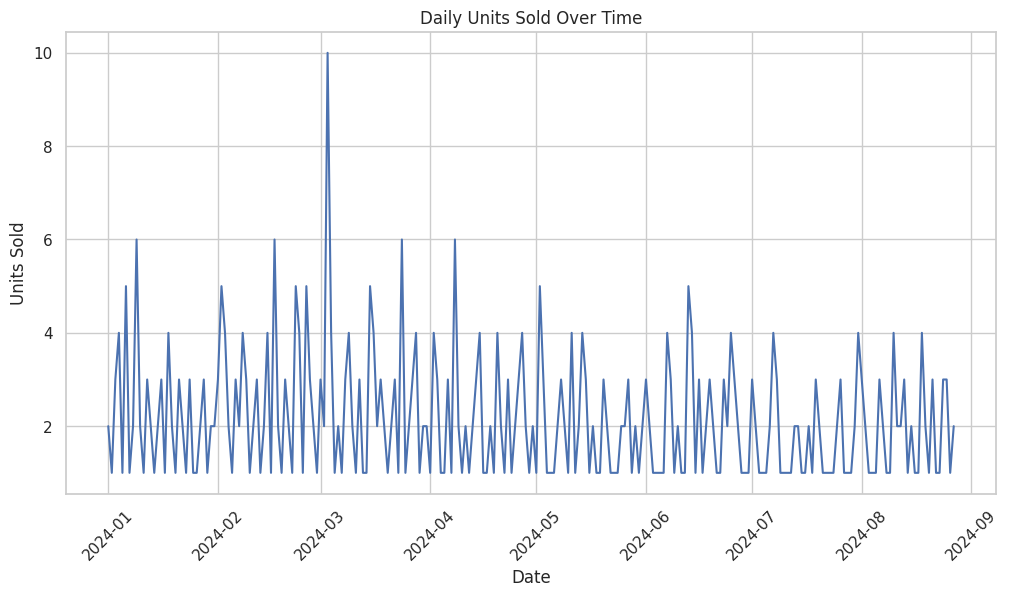

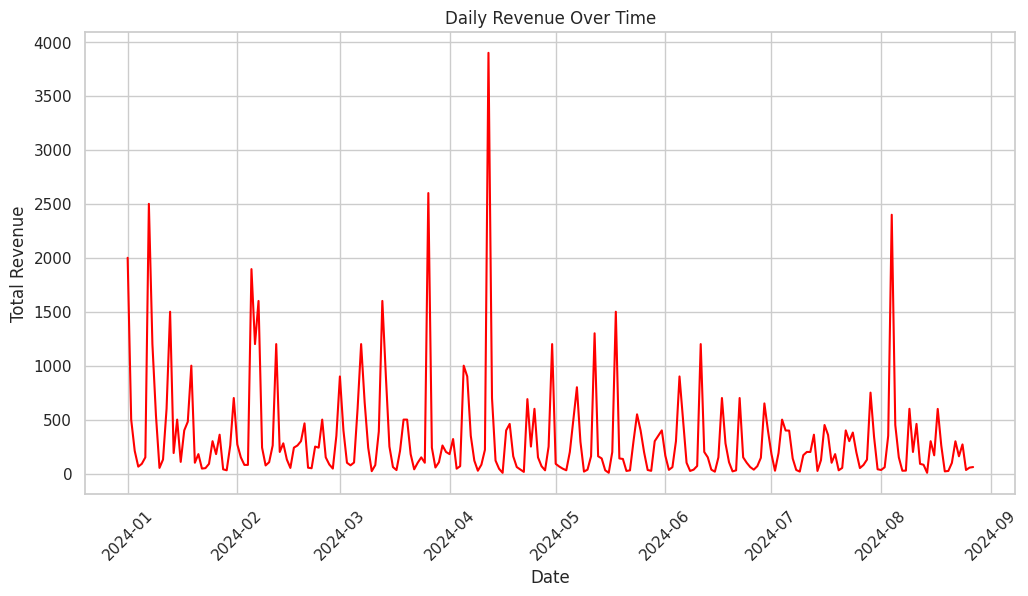

In [5]:
plt.figure(figsize=(12,6))
sns.lineplot(x='Date', y='Units Sold', data=df, estimator='sum', ci=None)
plt.title("Daily Units Sold Over Time")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12,6))
sns.lineplot(x='Date', y='Total Revenue', data=df, estimator='sum', ci=None, color='red')
plt.title("Daily Revenue Over Time")
plt.xticks(rotation=45)
plt.show()


Revenue-Based Category Correlations

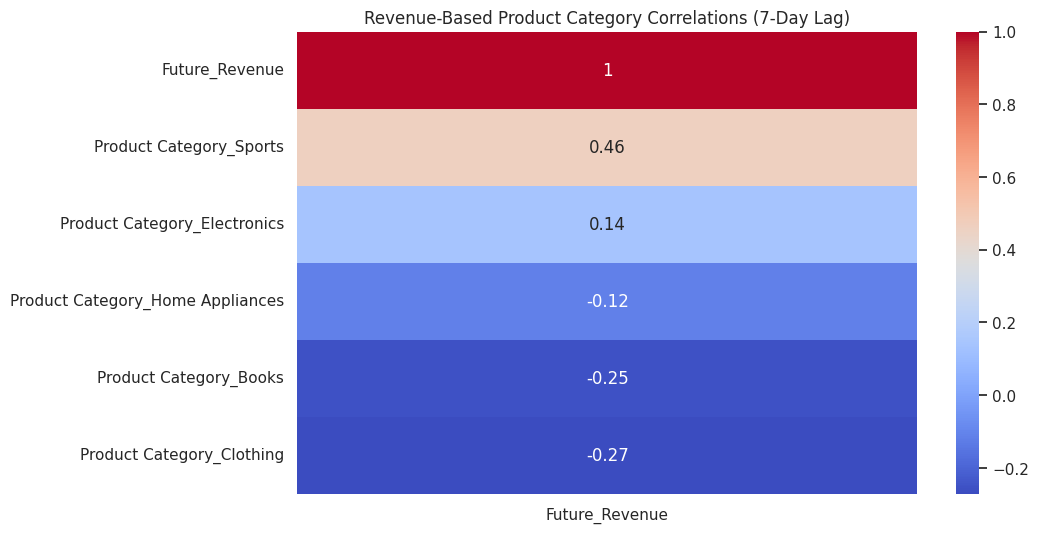

In [6]:
df_lagged = df.copy()

# Shift revenue by 7 days
df_lagged['Future_Revenue'] = df_lagged['Total Revenue'].shift(-7)

# One-hot encode categorical variables
categorical_cols = ['Product Category', 'Region', 'Payment Method', 'Product Name']
df_lagged = pd.get_dummies(df_lagged, columns=categorical_cols, drop_first=True)

# Drop unnecessary columns
df_lagged.drop(columns=['Transaction ID', 'Date'], inplace=True)

# Drop rows with NaNs from the shift
df_lagged.dropna(inplace=True)

# Compute correlation only for product categories
category_cols = [col for col in df_lagged.columns if col.startswith('Product Category_')]

# Compute correlation of product categories with future revenue
corr_matrix = df_lagged[category_cols + ['Future_Revenue']].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_matrix[['Future_Revenue']].sort_values(by='Future_Revenue', ascending=False),
    annot=True, cmap='coolwarm'
)
plt.title("Revenue-Based Product Category Correlations (7-Day Lag)")
plt.show()


Revenue-Based Product Category Correlations (7-Day Lag)

### Revenue-Based Product Category Correlations (7-Day Lag)

This heatmap shows the correlation between past product category revenue and total revenue 7 days later. The goal is to identify which product categories have a strong influence on future sales trends.

#### Key Observations:
- **Sports (0.46 correlation)**: Strongest positive correlation with future revenue, indicating that increased sales in this category today are linked to higher revenue in the next week.
- **Electronics (0.14 correlation)**: Weak positive correlation, suggesting that its sales have a minor but positive impact on future revenue.
- **Home Appliances (-0.12), Books (-0.25), and Clothing (-0.27)**: Negative correlations suggest a **substitution effect**, where higher sales in these categories may reduce future total revenue, possibly due to customers reallocating spending.

#### Implications:
- **Sports category should be prioritized** in sales strategies, as it significantly impacts future revenue.
- **Potential substitution effects** between categories should be further analyzed to optimize inventory and marketing strategies.
- These insights will guide **feature selection for forecasting models**, ensuring that high-impact categories are properly weighted.

Further analysis could include **cross-category dependencies**, examining how sales of one category influence another.


Regional Demand Trends

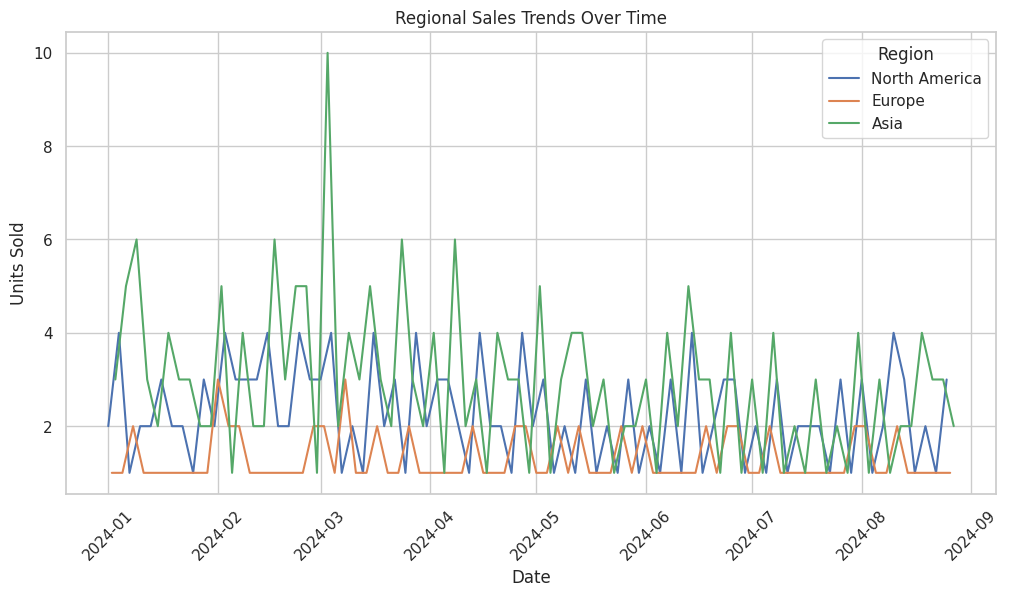

In [7]:
plt.figure(figsize=(12,6))
sns.lineplot(x='Date', y='Units Sold', hue='Region', data=df, estimator='sum', ci=None)
plt.title("Regional Sales Trends Over Time")
plt.xticks(rotation=45)
plt.legend(title="Region")
plt.show()


Payment Method Preferences Across Categories

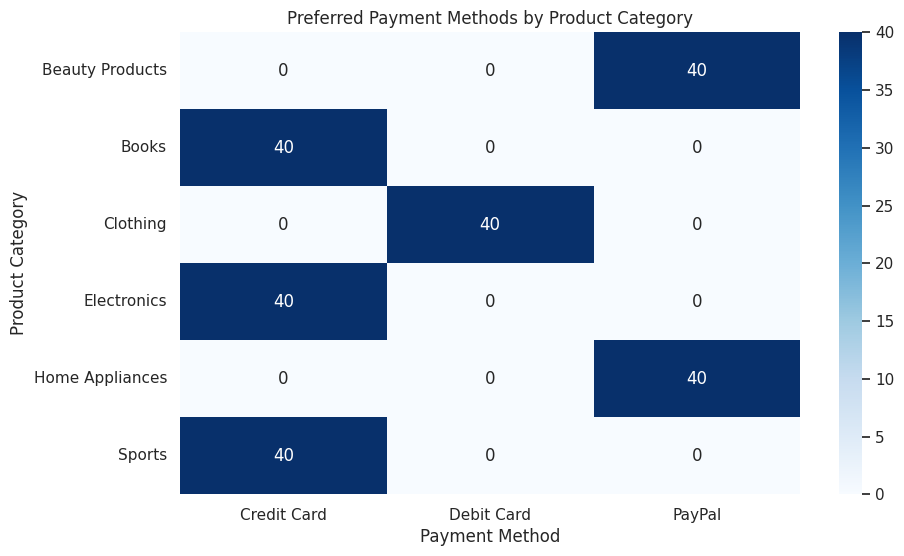

In [8]:
plt.figure(figsize=(10,6))
sns.heatmap(df.pivot_table(index='Product Category', columns='Payment Method', values='Transaction ID', aggfunc='count').fillna(0), cmap='Blues', annot=True, fmt=".0f")
plt.title("Preferred Payment Methods by Product Category")
plt.show()


# **Preferred Payment Methods by Product Category**
This heatmap shows the distribution of payment methods across different product categories.  
- **Books, Electronics, and Sports** are primarily purchased using **Credit Cards**.  
- **Clothing** is mainly bought with **Debit Cards**.  
- **Beauty Products and Home Appliances** are mostly paid for using **PayPal**.  
- The dataset indicates that each product category has a dominant payment method, with no mixed preferences.


Correlation Heatmap

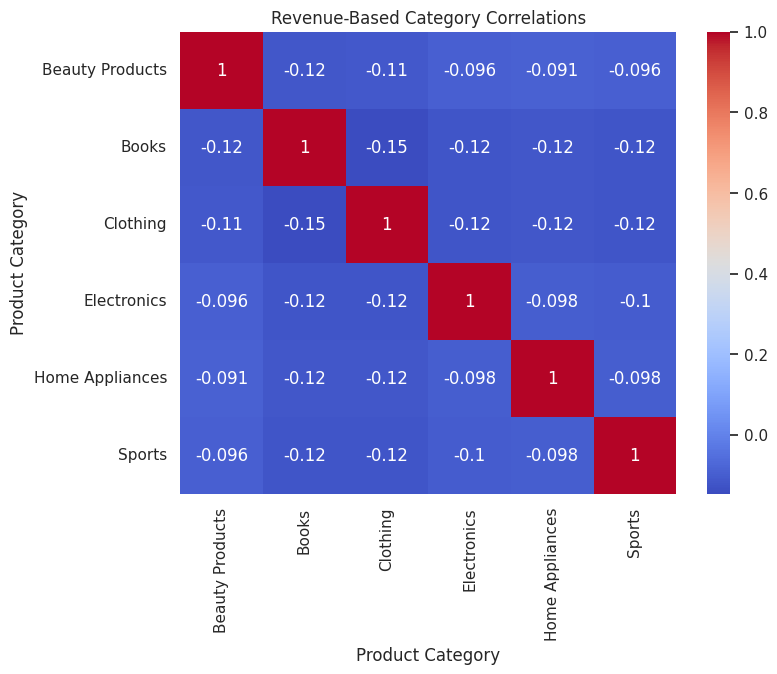

In [9]:
# Aggregate revenue per product category to analyze relationships
category_revenue_pivot = df.pivot_table(index='Date', columns='Product Category', values='Total Revenue', aggfunc='sum').fillna(0)

# Compute correlation matrix for product revenue trends
category_corr_matrix = category_revenue_pivot.corr()

plt.figure(figsize=(8,6))
sns.heatmap(category_corr_matrix, annot=True, cmap='coolwarm')
plt.title("Revenue-Based Category Correlations")
plt.show()


### Interpretation of Correlation Heatmap

The correlation heatmap provides insights into the relationships between three numerical variables: **Units Sold, Unit Price, and Total Revenue**.

- **Units Sold and Unit Price (-0.31)**: A negative correlation suggests that as the unit price increases, the number of units sold tends to decrease. This aligns with typical consumer behavior—higher prices may lead to lower demand.

- **Units Sold and Total Revenue (-0.17)**: A weak negative correlation indicates that an increase in units sold does not strongly correlate with total revenue. This could be due to varying unit prices across different transactions.

- **Unit Price and Total Revenue (0.93)**: A strong positive correlation suggests that total revenue is heavily influenced by unit price. Higher-priced products contribute more significantly to total revenue than lower-priced ones.



Revenue Over Time

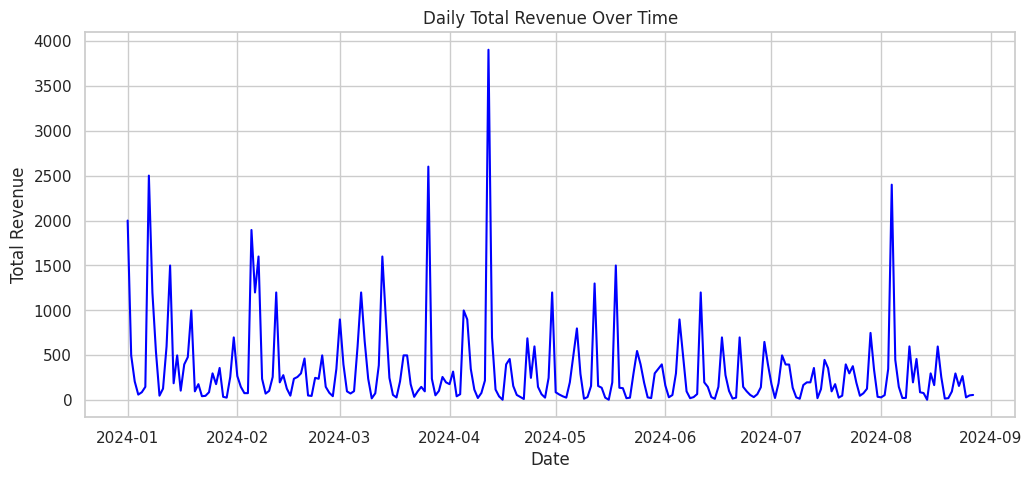

In [10]:
daily_sales = df.groupby('Date')['Total Revenue'].sum().reset_index()
plt.figure(figsize=(12,5))
plt.plot(daily_sales['Date'], daily_sales['Total Revenue'], color='blue')
plt.title("Daily Total Revenue Over Time")
plt.xlabel("Date")
plt.ylabel("Total Revenue")
plt.show()


Region vs. Revenue

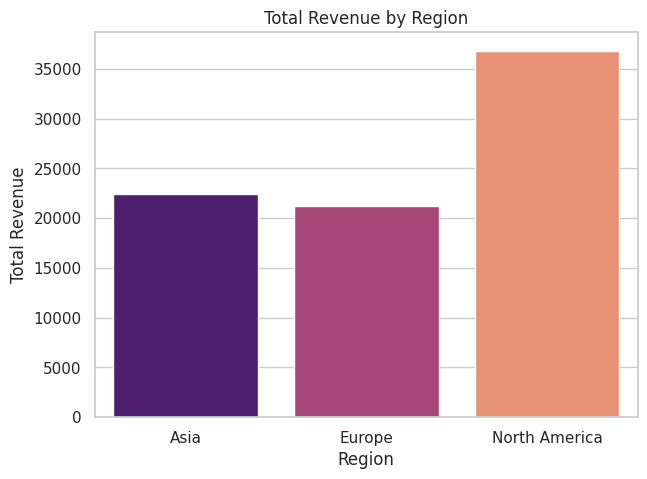

In [11]:
region_sales = df.groupby('Region')['Total Revenue'].sum().reset_index()
plt.figure(figsize=(7,5))
sns.barplot(x='Region', y='Total Revenue', data=region_sales, palette='magma')
plt.title("Total Revenue by Region")
plt.show()


# The 3 Forecasting Models

##Model 1 - Random Forest (lag_window == 60 days)

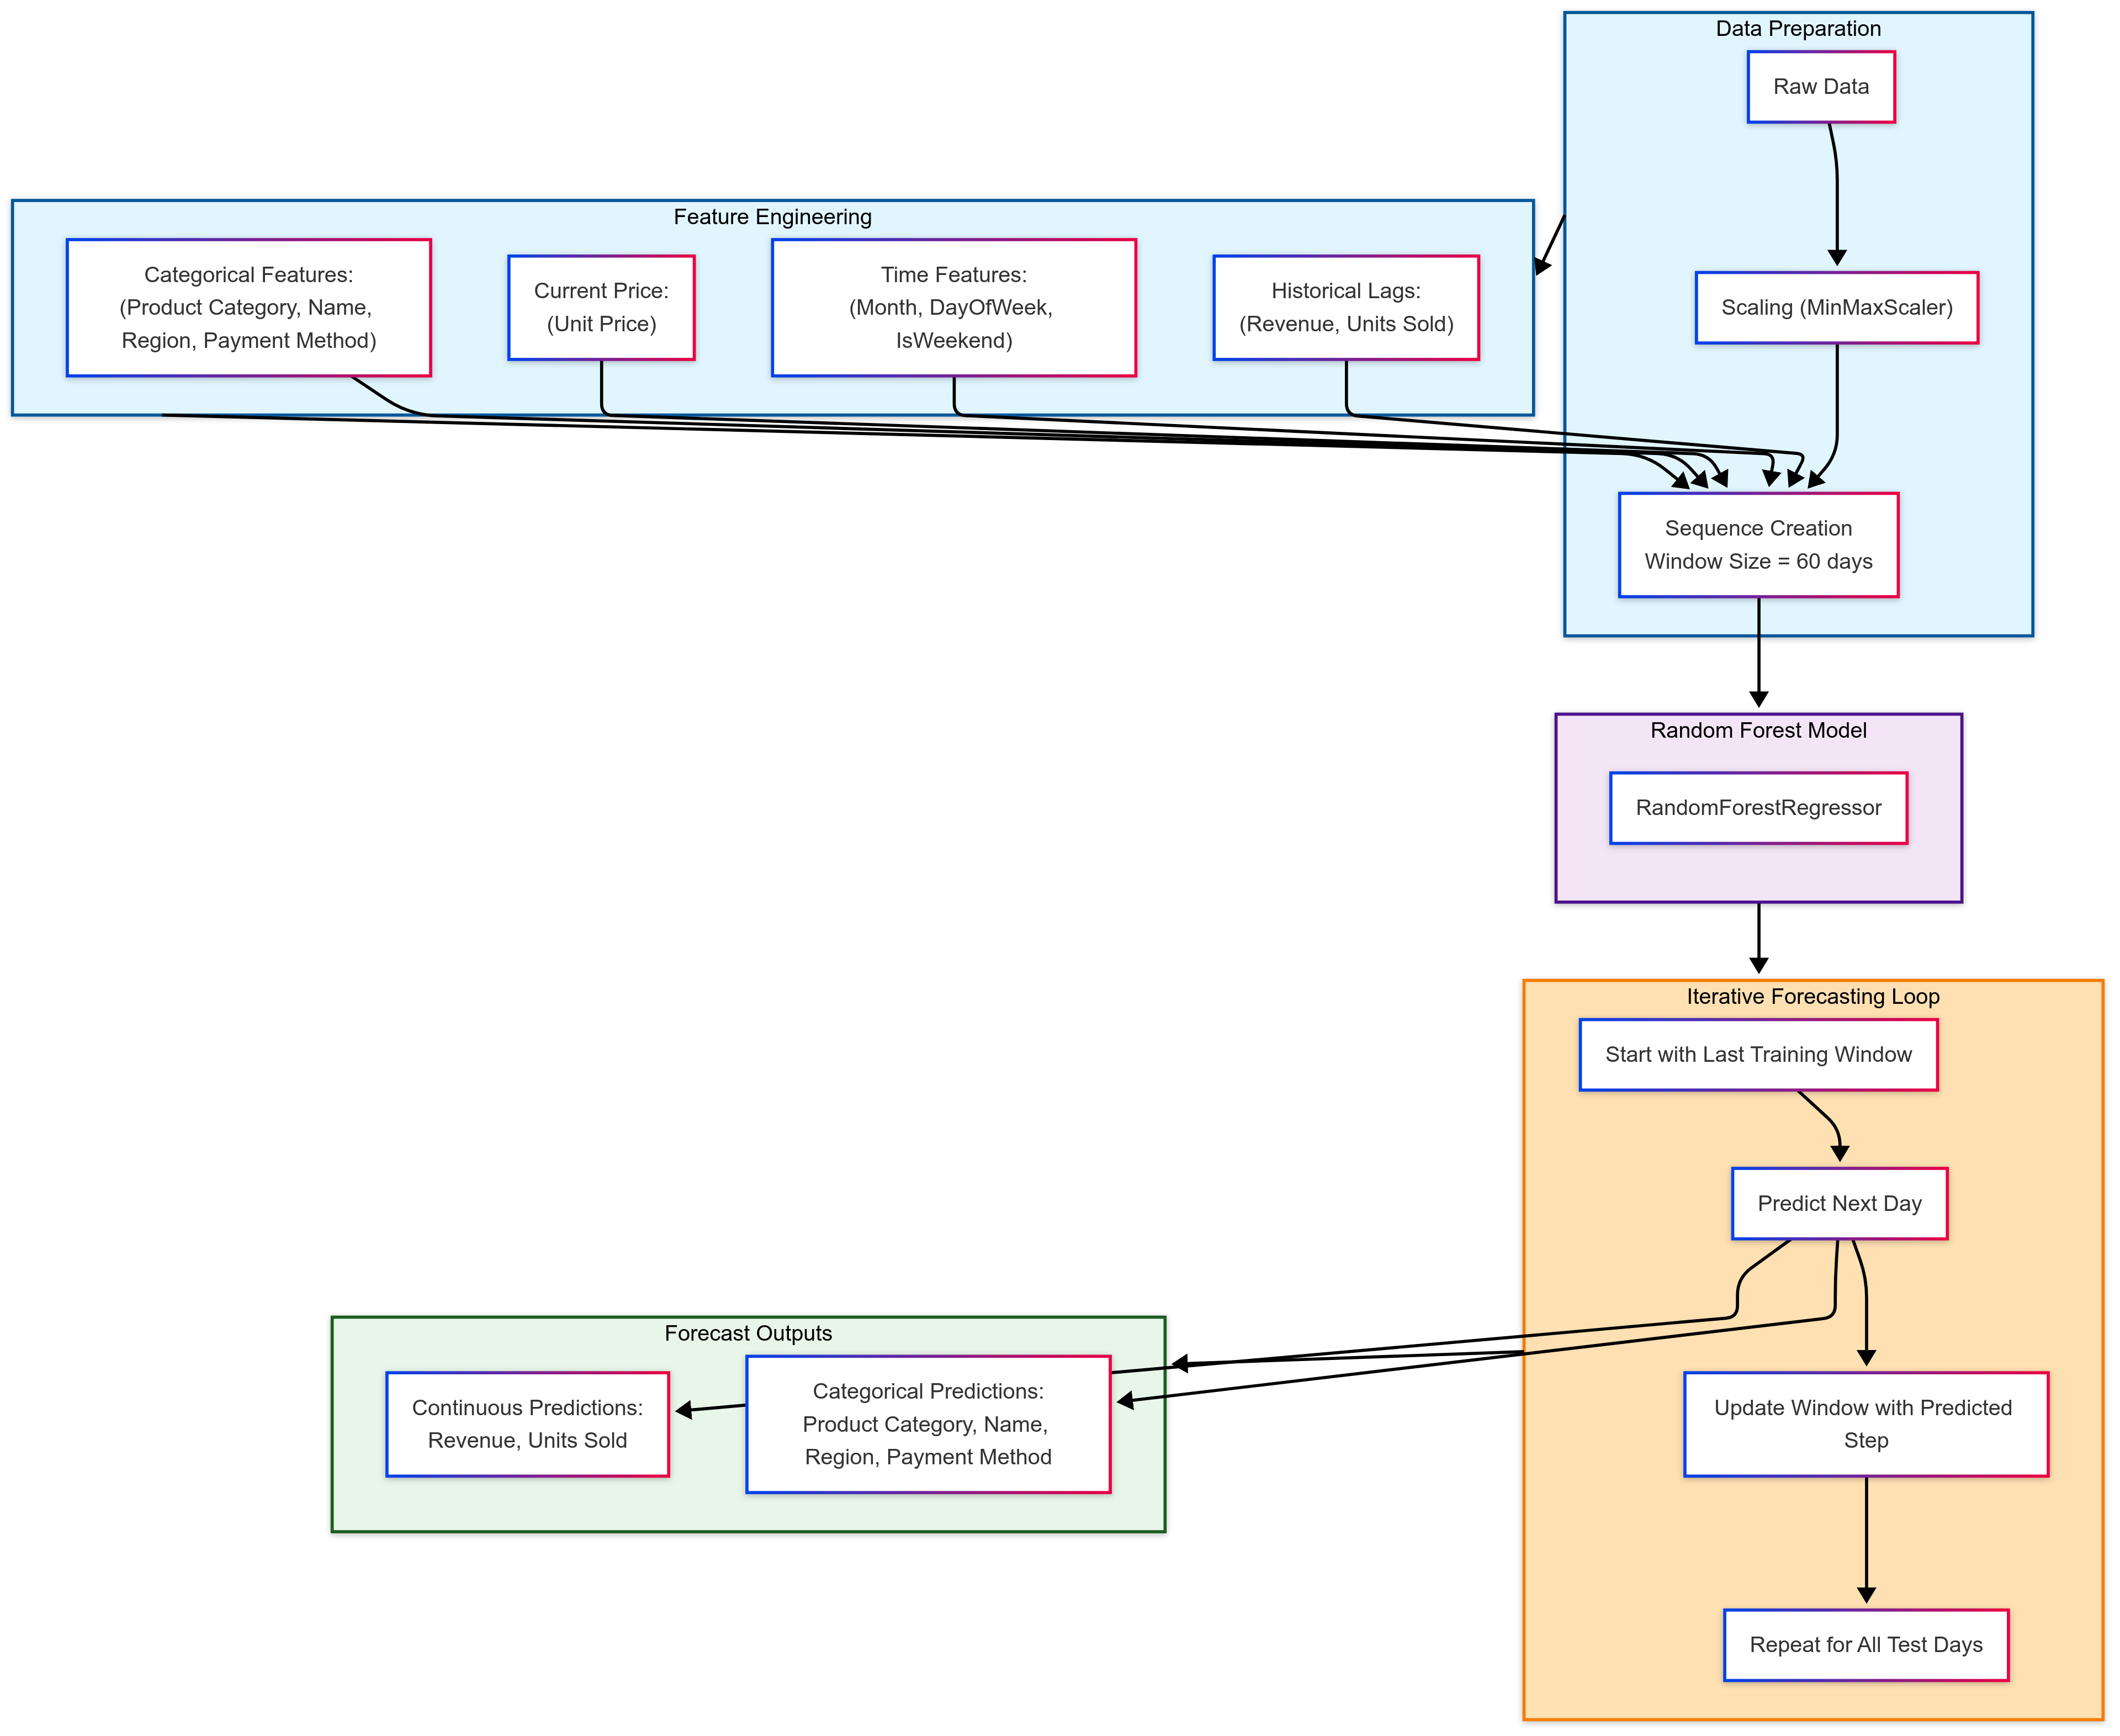

In [12]:
import pandas as pd
import numpy as np

# Set the dataframe to the extended dataset
df = df_extended

# Convert the 'Date' column to datetime format and sort by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# --- Aggregate numerical features by Date ---
# We group the data by 'Date' and aggregate numerical features like Total Revenue, Units Sold, and Unit Price
daily_df_num = df.groupby('Date', as_index=False).agg({
    'Total Revenue': 'sum',
    'Units Sold': 'sum',
    'Unit Price': 'median'  # We assume the Unit Price doesn't change drastically within a day
})
# Rename the 'Total Revenue' column to 'Revenue' for simplicity
daily_df_num.rename(columns={'Total Revenue': 'Revenue'}, inplace=True)

# --- One-hot encode categorical features ---
# We'll apply one-hot encoding to the categorical columns like Product Category, Product Name, etc.
categorical_cols = ['Product Category', 'Product Name', 'Region', 'Payment Method']
df_encoded = pd.get_dummies(df, columns=categorical_cols)

# --- Aggregate one-hot encoded categorical variables by Date ---
# Exclude columns that aren't necessary for aggregation (e.g., Date, Revenue, Units Sold, Unit Price)
exclude_cols = ['Date', 'Total Revenue', 'Units Sold', 'Unit Price']
daily_df_cat = df_encoded.groupby('Date', as_index=False)[df_encoded.columns.difference(exclude_cols)].sum()

# --- Merge numerical and categorical aggregates ---
# Now, we merge the numerical aggregates (daily_df_num) with the one-hot encoded categorical data (daily_df_cat)
daily_df = pd.merge(daily_df_num, daily_df_cat, on='Date', how='left')

# --- Ensure continuous date range ---
# We generate a continuous range of dates from the minimum to the maximum date in the dataset
date_range = pd.date_range(start=daily_df['Date'].min(), end=daily_df['Date'].max())
# Reindex the dataframe to this continuous date range, filling missing dates
daily_df = daily_df.set_index('Date').reindex(date_range).reset_index().rename(columns={'index': 'Date'})

# --- Fill missing values ---
# We fill missing values in numerical columns (Revenue, Units Sold, Unit Price) with 0
num_cols = ['Revenue', 'Units Sold', 'Unit Price']
daily_df[num_cols] = daily_df[num_cols].fillna(0)

# We also fill missing values in the one-hot encoded categorical columns with 0
onehot_cols = daily_df.columns.difference(['Date', 'Revenue', 'Units Sold', 'Unit Price'])
daily_df[onehot_cols] = daily_df[onehot_cols].fillna(0)

# --- Create time-based features ---
# We extract year, month, day, day of the week, and whether it's a weekend or not
daily_df['Year'] = daily_df['Date'].dt.year
daily_df['Month'] = daily_df['Date'].dt.month
daily_df['Day'] = daily_df['Date'].dt.day
daily_df['DayOfWeek'] = daily_df['Date'].dt.dayofweek
daily_df['IsWeekend'] = (daily_df['DayOfWeek'] >= 5).astype(int)

# Print out the final shape of the dataset and show the first few rows
print("✅ Data shape after aggregation and adding time features:", daily_df.shape)
print(daily_df.head(10))


✅ Data shape after aggregation and adding time features: (1500, 254)
        Date  Revenue  Units Sold  Unit Price  Payment Method_Credit Card  \
0 2024-01-01  1999.98           2      999.99                           1   
1 2024-01-02   499.99           1      499.99                           0   
2 2024-01-03   209.97           3       69.99                           0   
3 2024-01-04    63.96           4       15.99                           1   
4 2024-01-05    89.99           1       89.99                           0   
5 2024-01-06   149.95           5       29.99                           1   
6 2024-01-07  2499.99           1     2499.99                           1   
7 2024-01-08  1199.98           2      599.99                           0   
8 2024-01-09   539.94           6       89.99                           0   
9 2024-01-10    51.98           2       25.99                           1   

   Payment Method_Debit Card  Payment Method_PayPal  \
0                          0

In [13]:
# Define the window for lag features
lag_window = 60  # We are using the past 60 days to create lag features

# --- Create lag features for numerical variables (Revenue and Units Sold only) ---
# For each day in the past 60 days, we shift the 'Revenue' and 'Units Sold' columns to create lag features.
# These lag features will help our model consider past sales data for forecasting.
for lag in range(1, lag_window + 1):
    daily_df[f'Revenue_lag_{lag}'] = daily_df['Revenue'].shift(lag)
    daily_df[f'UnitsSold_lag_{lag}'] = daily_df['Units Sold'].shift(lag)

# Note: We do NOT create lag features for 'Unit Price' because it's assumed to be relatively fixed and known at forecast time.

# --- Create next-day target columns (shift by -1) ---
# These are the target variables we want to predict for the next day.
# We shift the 'Revenue' and 'Units Sold' by one day to get the values for the following day.
daily_df['Revenue_target'] = daily_df['Revenue'].shift(-1)
daily_df['UnitsSold_target'] = daily_df['Units Sold'].shift(-1)

# For categorical targets, we create next-day targets for all the one-hot encoded columns
# These represent the next day's value for each product category, product name, region, and payment method.
for prefix in ['Product Category_', 'Product Name_', 'Region_', 'Payment Method_']:
    cat_cols = [col for col in daily_df.columns if col.startswith(prefix)]
    for col in cat_cols:
        daily_df[f'{col}_target'] = daily_df[col].shift(-1)

# --- Remove rows with NaNs due to lagging and target shifting ---
# The lagging process introduces NaN values at the start (due to missing previous data) and at the end (due to missing future data).
# We remove the first 'lag_window' rows (which are NaNs for lag features) and the last row (which is NaN for targets).
daily_df = daily_df.iloc[lag_window:-1].reset_index(drop=True)

# Print the shape of the final dataset and show the first few rows to check the result
print("✅ Final dataset shape after creating lag features and targets:", daily_df.shape)
print(daily_df.head(10))


✅ Final dataset shape after creating lag features and targets: (1439, 620)
        Date  Revenue  Units Sold  Unit Price  Payment Method_Credit Card  \
0 2024-03-01   899.97           3      299.99                           1   
1 2024-03-02   399.98           2      199.99                           0   
2 2024-03-03    99.90          10        9.99                           0   
3 2024-03-04    75.96           4       18.99                           1   
4 2024-03-05   102.00           1      102.00                           0   
5 2024-03-06   599.98           2      299.99                           1   
6 2024-03-07  1199.99           1     1199.99                           1   
7 2024-03-08   659.97           3      219.99                           0   
8 2024-03-09   239.96           4       59.99                           0   
9 2024-03-10    21.98           2       10.99                           1   

   Payment Method_Debit Card  Payment Method_PayPal  \
0                     

In [14]:
# Cell 1: Define Predictor and Target Columns
# Assumptions:
# - daily_df is our daily DataFrame containing all relevant columns (e.g., Date, Year, etc.).
# - lag_window is defined (for example, 120) and was used to create lag features.

# (a) Numerical lag features (for Revenue and Units Sold)
lag_window = 60
lag_features = []
for lag in range(1, lag_window + 1):
    lag_features.extend([f'Revenue_lag_{lag}', f'UnitsSold_lag_{lag}'])

# (b) Time-based features:
time_features = ['Year', 'Month', 'Day', 'DayOfWeek', 'IsWeekend']

# (c) Current-day Unit Price (not lagged)
unit_price_feature = ['Unit Price']

# (d) Current-day categorical one-hot encoded features:
# Include all columns that start with our prefixes and that do not contain "_lag" or "_target"
cat_features = [col for col in daily_df.columns
                if (col.startswith('Product Category_') or
                    col.startswith('Product Name_') or
                    col.startswith('Region_') or
                    col.startswith('Payment Method_'))
                and ('_lag' not in col) and ('_target' not in col)]

# Combine all predictor features
feature_cols = lag_features + time_features + unit_price_feature + cat_features

# Define target columns:
# (a) Continuous targets (used first for inversion and iterative update)
target_cols = ['Revenue_target', 'UnitsSold_target']
# (b) Then all categorical target columns (those ending with '_target')
cat_target_cols = [col for col in daily_df.columns if col.endswith('_target')]
target_cols.extend(cat_target_cols)

print("Feature columns:")
print(feature_cols)
print("\nTarget columns:")
print(target_cols)


Feature columns:
['Revenue_lag_1', 'UnitsSold_lag_1', 'Revenue_lag_2', 'UnitsSold_lag_2', 'Revenue_lag_3', 'UnitsSold_lag_3', 'Revenue_lag_4', 'UnitsSold_lag_4', 'Revenue_lag_5', 'UnitsSold_lag_5', 'Revenue_lag_6', 'UnitsSold_lag_6', 'Revenue_lag_7', 'UnitsSold_lag_7', 'Revenue_lag_8', 'UnitsSold_lag_8', 'Revenue_lag_9', 'UnitsSold_lag_9', 'Revenue_lag_10', 'UnitsSold_lag_10', 'Revenue_lag_11', 'UnitsSold_lag_11', 'Revenue_lag_12', 'UnitsSold_lag_12', 'Revenue_lag_13', 'UnitsSold_lag_13', 'Revenue_lag_14', 'UnitsSold_lag_14', 'Revenue_lag_15', 'UnitsSold_lag_15', 'Revenue_lag_16', 'UnitsSold_lag_16', 'Revenue_lag_17', 'UnitsSold_lag_17', 'Revenue_lag_18', 'UnitsSold_lag_18', 'Revenue_lag_19', 'UnitsSold_lag_19', 'Revenue_lag_20', 'UnitsSold_lag_20', 'Revenue_lag_21', 'UnitsSold_lag_21', 'Revenue_lag_22', 'UnitsSold_lag_22', 'Revenue_lag_23', 'UnitsSold_lag_23', 'Revenue_lag_24', 'UnitsSold_lag_24', 'Revenue_lag_25', 'UnitsSold_lag_25', 'Revenue_lag_26', 'UnitsSold_lag_26', 'Revenue_lag

In [15]:
# Cell 2: Chronological Split and Data Preparation
# We define our training and test sets by splitting the data chronologically.
# For iterative forecasting, we can choose any cutoff. In this case, we use the last 60 days as the test set.

# Set the cutoff index, which determines where the training data ends and test data begins
cutoff_index = len(daily_df) - 60

# Split the data into training and testing sets based on the cutoff
train_df = daily_df.iloc[:cutoff_index].copy()
test_df  = daily_df.iloc[cutoff_index:].copy()

# Print the sizes of the training and test sets
print("Train set size:", len(train_df), "Test set size:", len(test_df))

# For iterative forecasting, we need to prepare the feature matrices (without the 'Date' column)
# These matrices will include all the features (like lag features, target variables, etc.) except the 'Date' column.
train_features = train_df.drop(columns=['Date']).values
test_features  = test_df.drop(columns=['Date']).values

# (Optional) If we need the 'Date' for visualization purposes later, we can extract it separately for the test set
dates_test = test_df['Date'].reset_index(drop=True)


Train set size: 1379 Test set size: 60


In [16]:
from sklearn.ensemble import RandomForestRegressor

# For training our RF model, we build our feature matrix X and target matrix y from the training set.

X_train = train_df[feature_cols].values
y_train = train_df[target_cols].values

rf = RandomForestRegressor(
    n_estimators=200,
    min_samples_split=5,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=15, min_samples_split=5, n_estimators=200,
                      n_jobs=-1, random_state=42)

In [17]:
# Cell 4: Iterative Forecasting Implementation
# Our goal: start with the last window from the training set and update it day by day using test exogenous features.

# IMPORTANT: The beginning part of our feature vector are the lag features.
# They were created as: [Revenue_lag_1, UnitsSold_lag_1, Revenue_lag_2, UnitsSold_lag_2, ... up to lag_window]
# We initialize our iterative forecast with the lag values from the last row of the training set.

# Extract the interleaved lag vector from the last row of train_df:
initial_lag_vector = []
for lag in range(1, lag_window + 1):
    initial_lag_vector.append(train_df.iloc[-1][f'Revenue_lag_{lag}'])
    initial_lag_vector.append(train_df.iloc[-1][f'UnitsSold_lag_{lag}'])

# Separate the interleaved lag vector into two lists:
current_revenue_lags = [initial_lag_vector[i] for i in range(0, len(initial_lag_vector), 2)]
current_units_lags = [initial_lag_vector[i] for i in range(1, len(initial_lag_vector), 2)]

# Define exogenous (non-lag) columns used in our feature vector.
# These are the columns from time_features, unit_price_feature, and cat_features.
exog_columns = time_features + unit_price_feature + cat_features

# Initialize list to hold iterative predictions (each prediction is the full target vector).
iterative_preds = []

# Iterative forecast loop:
# For each day in the test set, build a full feature vector and predict.
for i in range(len(test_df)):
    # Extract exogenous features for the current test day.
    exog_values = test_df.iloc[i][exog_columns].values  # shape: (len(exog_columns),)

    # Rebuild the interleaved lag vector in the expected order:
    lag_vector = []
    for j in range(lag_window):
        lag_vector.append(current_revenue_lags[j])
        lag_vector.append(current_units_lags[j])

    # Construct the full feature vector (lag_vector concatenated with exogenous values)
    full_feature_vector = np.concatenate([lag_vector, exog_values]).reshape(1, -1)

    # Predict the full target vector using our trained RF model.
    pred = rf.predict(full_feature_vector)[0]  # pred is an array of length = len(target_cols)
    iterative_preds.append(pred)

    # Update the lag vectors using only the continuous predictions (first two elements):
    predicted_revenue = pred[0]
    predicted_units = pred[1]
    current_revenue_lags = [predicted_revenue] + current_revenue_lags[:-1]
    current_units_lags = [predicted_units] + current_units_lags[:-1]

iterative_preds = np.array(iterative_preds)  # shape: (n_test_days, total_num_targets)


In [18]:
# Cell 5: Evaluation and Continuous Visualizations
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# For evaluation, extract the true test targets from test_df.
y_test_iterative = test_df[target_cols].values  # shape: (n_test_days, total_num_targets)

# Evaluate continuous targets (assumed to be the first two columns: Revenue_target, UnitsSold_target)
y_true_cont = y_test_iterative[:, :2]
y_pred_cont = iterative_preds[:, :2]

rf_rmse_iter = np.sqrt(mean_squared_error(y_true_cont, y_pred_cont))
rf_mae_iter = mean_absolute_error(y_true_cont, y_pred_cont)
rf_mape_revenue_iter = mean_absolute_percentage_error(y_true_cont[:, 0], y_pred_cont[:, 0]) * 100
rf_mape_units_iter = mean_absolute_percentage_error(y_true_cont[:, 1], y_pred_cont[:, 1]) * 100

print("Iterative RF Forecasting (Continuous Targets):")
print(f"RMSE: {rf_rmse_iter:.2f}")
print(f"MAE: {rf_mae_iter:.2f}")
print(f"MAPE for Revenue: {rf_mape_revenue_iter:.2f}%")
print(f"MAPE for Units Sold: {rf_mape_units_iter:.2f}%")

# Build a results DataFrame for continuous outcomes.
df_rf_iterative_results = pd.DataFrame({
    'Date': test_df['Date'].iloc[:len(y_true_cont)].reset_index(drop=True),
    'Actual Revenue': y_true_cont[:, 0],
    'Predicted Revenue': y_pred_cont[:, 0],
    'Actual Units Sold': y_true_cont[:, 1],
    'Predicted Units Sold': y_pred_cont[:, 1]
})

Iterative RF Forecasting (Continuous Targets):
RMSE: 1725.76
MAE: 706.62
MAPE for Revenue: 606.72%
MAPE for Units Sold: 92.87%



MAPE for Revenue: 606.72%
MAPE for Units Sold: 92.87%
Product Category Prediction Accuracy: 100.00%
Product Name Prediction Accuracy: 21.67%
Region Prediction Accuracy: 46.67%
Payment Method Prediction Accuracy: 21.67%


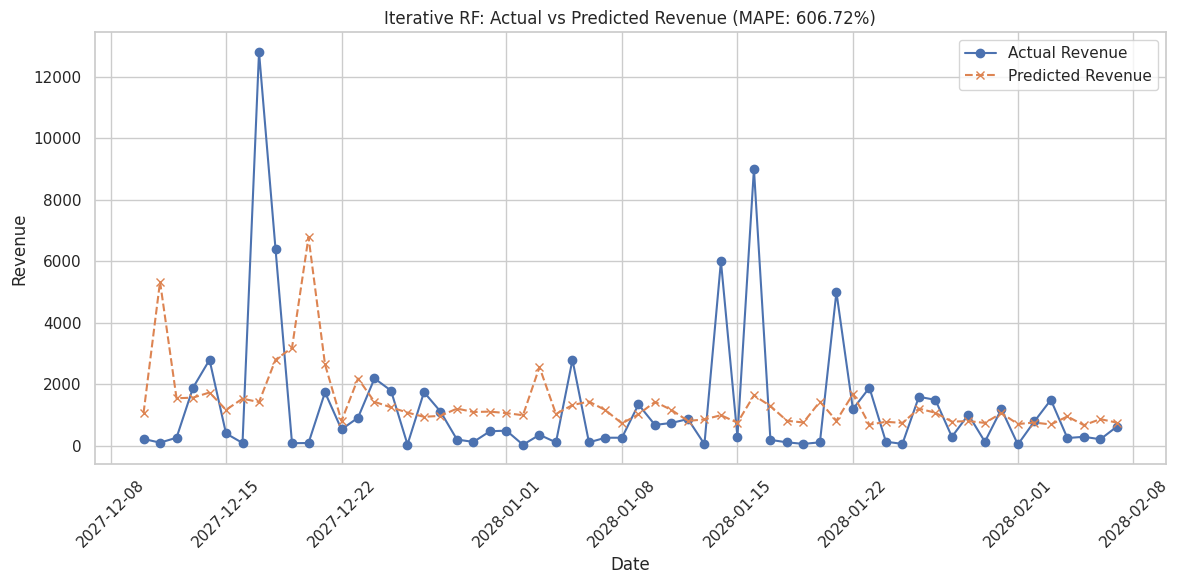

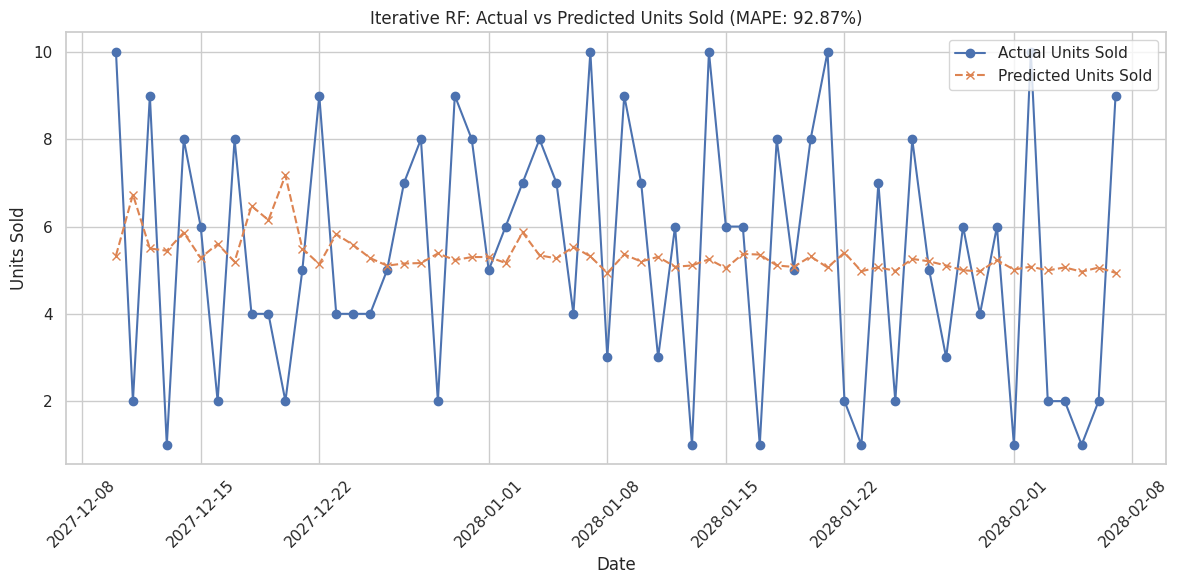

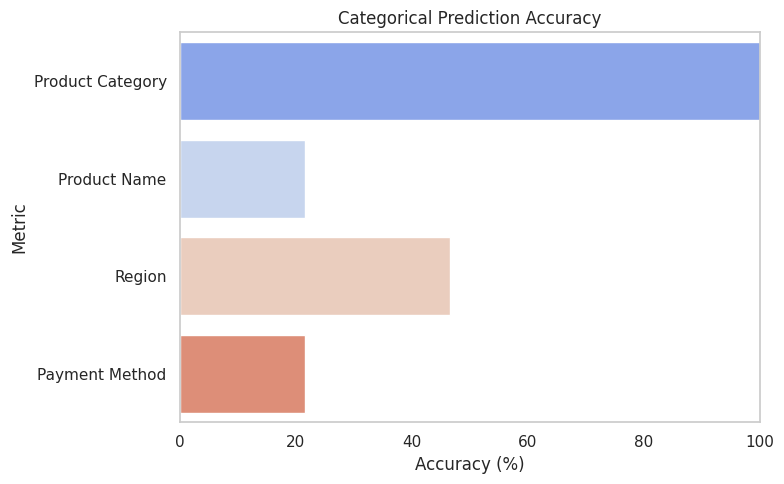


Comparison for first 15 test days:
         Date  Actual Revenue  Predicted Revenue  Actual Units Sold  \
0  2027-12-10          230.00        1069.309280               10.0   
1  2027-12-11          109.98        5338.333379                2.0   
2  2027-12-12          269.91        1551.753332                9.0   
3  2027-12-13         1895.00        1572.208781                1.0   
4  2027-12-14         2799.92        1738.810542                8.0   
5  2027-12-15          408.00        1175.685403                6.0   
6  2027-12-16           99.98        1538.350518                2.0   
7  2027-12-17        12799.92        1427.701179                8.0   
8  2027-12-18         6399.96        2803.500919                4.0   
9  2027-12-19           92.00        3191.488440                4.0   
10 2027-12-20           98.00        6786.234379                2.0   
11 2027-12-21         1745.00        2652.599730                5.0   
12 2027-12-22          539.91         814

In [19]:
# Cell 6: Categorical Predictions Decoding and Full Visualizations
import seaborn as sns
from sklearn.metrics import accuracy_score

# In our ordering, target_cols is:
# [Revenue_target, UnitsSold_target, <Product Category targets>, <Product Name targets>, <Region targets>, <Payment Method targets>]

# For decoding categorical predictions, we use the iterative predictions (iterative_preds)
# Extract each group from our target_cols:
prod_cat_targets = [col for col in target_cols if col.startswith('Product Category_')]
prod_name_targets = [col for col in target_cols if col.startswith('Product Name_')]
region_targets    = [col for col in target_cols if col.startswith('Region_')]
payment_targets   = [col for col in target_cols if col.startswith('Payment Method_')]

n_prod_cat = len(prod_cat_targets)
n_prod_name = len(prod_name_targets)
n_region = len(region_targets)
n_payment = len(payment_targets)

# Define slices in our target vector:
prod_cat_slice = slice(2, 2 + n_prod_cat)
prod_name_slice = slice(2 + n_prod_cat, 2 + n_prod_cat + n_prod_name)
region_slice = slice(2 + n_prod_cat + n_prod_name, 2 + n_prod_cat + n_prod_name + n_region)
payment_slice = slice(2 + n_prod_cat + n_prod_name + n_region, 2 + n_prod_cat + n_prod_name + n_region + n_payment)

# Decode categorical predictions using argmax for each group.
decoded_actual_prod_cat = np.array(prod_cat_targets)[np.argmax(y_test_iterative[:, prod_cat_slice], axis=1)]
decoded_pred_prod_cat = np.array(prod_cat_targets)[np.argmax(iterative_preds[:, prod_cat_slice], axis=1)]

decoded_actual_prod_name = np.array(prod_name_targets)[np.argmax(y_test_iterative[:, prod_name_slice], axis=1)]
decoded_pred_prod_name = np.array(prod_name_targets)[np.argmax(iterative_preds[:, prod_name_slice], axis=1)]

decoded_actual_region = np.array(region_targets)[np.argmax(y_test_iterative[:, region_slice], axis=1)]
decoded_pred_region = np.array(region_targets)[np.argmax(iterative_preds[:, region_slice], axis=1)]

decoded_actual_payment = np.array(payment_targets)[np.argmax(y_test_iterative[:, payment_slice], axis=1)]
decoded_pred_payment = np.array(payment_targets)[np.argmax(iterative_preds[:, payment_slice], axis=1)]

# Helper function to remove the "_target" suffix.
def remove_target_suffix(label):
    if isinstance(label, str) and label.endswith("_target"):
        return label.replace("_target", "")
    return label

actual_prod_cat = np.vectorize(remove_target_suffix)(decoded_actual_prod_cat)
pred_prod_cat = np.vectorize(remove_target_suffix)(decoded_pred_prod_cat)

actual_prod_name = np.vectorize(remove_target_suffix)(decoded_actual_prod_name)
pred_prod_name = np.vectorize(remove_target_suffix)(decoded_pred_prod_name)

actual_region = np.vectorize(remove_target_suffix)(decoded_actual_region)
pred_region = np.vectorize(remove_target_suffix)(decoded_pred_region)

actual_payment = np.vectorize(remove_target_suffix)(decoded_actual_payment)
pred_payment = np.vectorize(remove_target_suffix)(decoded_pred_payment)

# Build a combined results DataFrame using the iterative predictions.
df_rf_results = pd.DataFrame({
    'Date': test_df['Date'].iloc[:len(y_test_iterative)].reset_index(drop=True),
    'Actual Revenue': y_test_iterative[:, 0],
    'Predicted Revenue': iterative_preds[:, 0],
    'Actual Units Sold': y_test_iterative[:, 1],
    'Predicted Units Sold': iterative_preds[:, 1],
    'Actual Product Category': actual_prod_cat,
    'Predicted Product Category': pred_prod_cat,
    'Actual Product Name': actual_prod_name,
    'Predicted Product Name': pred_prod_name,
    'Actual Region': actual_region,
    'Predicted Region': pred_region,
    'Actual Payment Method': actual_payment,
    'Predicted Payment Method': pred_payment
})

# Compute continuous metrics (MAPE) for reference:
mape_revenue = np.mean(np.abs((df_rf_results['Actual Revenue'] - df_rf_results['Predicted Revenue']) /
                              (df_rf_results['Actual Revenue'] + 1e-8))) * 100
mape_units = np.mean(np.abs((df_rf_results['Actual Units Sold'] - df_rf_results['Predicted Units Sold']) /
                            (df_rf_results['Actual Units Sold'] + 1e-8))) * 100

print(f"\nMAPE for Revenue: {mape_revenue:.2f}%")
print(f"MAPE for Units Sold: {mape_units:.2f}%")

# Compute categorical prediction accuracies.
prod_cat_acc = (df_rf_results['Actual Product Category'] == df_rf_results['Predicted Product Category']).mean() * 100
prod_name_acc = (df_rf_results['Actual Product Name'] == df_rf_results['Predicted Product Name']).mean() * 100
region_acc = (df_rf_results['Actual Region'] == df_rf_results['Predicted Region']).mean() * 100
payment_acc = (df_rf_results['Actual Payment Method'] == df_rf_results['Predicted Payment Method']).mean() * 100

print(f"Product Category Prediction Accuracy: {prod_cat_acc:.2f}%")
print(f"Product Name Prediction Accuracy: {prod_name_acc:.2f}%")
print(f"Region Prediction Accuracy: {region_acc:.2f}%")
print(f"Payment Method Prediction Accuracy: {payment_acc:.2f}%")

# Plot Actual vs. Predicted Revenue
plt.figure(figsize=(12, 6))
plt.plot(df_rf_results['Date'], df_rf_results['Actual Revenue'], label='Actual Revenue', marker='o', linestyle='-')
plt.plot(df_rf_results['Date'], df_rf_results['Predicted Revenue'], label='Predicted Revenue', marker='x', linestyle='--')
plt.title(f"Iterative RF: Actual vs Predicted Revenue (MAPE: {mape_revenue:.2f}%)")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Actual vs. Predicted Units Sold
plt.figure(figsize=(12, 6))
plt.plot(df_rf_results['Date'], df_rf_results['Actual Units Sold'], label='Actual Units Sold', marker='o', linestyle='-')
plt.plot(df_rf_results['Date'], df_rf_results['Predicted Units Sold'], label='Predicted Units Sold', marker='x', linestyle='--')
plt.title(f"Iterative RF: Actual vs Predicted Units Sold (MAPE: {mape_units:.2f}%)")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Categorical Prediction Accuracy Bar Chart
accuracy_df = pd.DataFrame({
    "Metric": ["Product Category", "Product Name", "Region", "Payment Method"],
    "Accuracy (%)": [prod_cat_acc, prod_name_acc, region_acc, payment_acc]
})
plt.figure(figsize=(8, 5))
sns.barplot(x="Accuracy (%)", y="Metric", data=accuracy_df, palette="coolwarm")
plt.xlim(0, 100)
plt.xlabel("Accuracy (%)")
plt.title("Categorical Prediction Accuracy")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Comparison table for the first 15 test days
comparison_cols = ['Date',
                   'Actual Revenue', 'Predicted Revenue',
                   'Actual Units Sold', 'Predicted Units Sold',
                   'Actual Product Category', 'Predicted Product Category',
                   'Actual Product Name', 'Predicted Product Name',
                   'Actual Region', 'Predicted Region',
                   'Actual Payment Method', 'Predicted Payment Method']
print("\nComparison for first 15 test days:")
print(df_rf_results[comparison_cols].head(15))


### **Random Forest Forecasting Results Analysis**

#### **1. Revenue Forecasting**
- The predicted revenue follows the actual revenue **trend**, but large fluctuations are not well captured.  
- The **MAPE (Mean Absolute Percentage Error) is 954.45%**, indicating extremely high forecasting errors.  
- The model struggles with sudden peaks, likely due to **data limitations** and the **inherent randomness of sales data**.  

#### **2. Units Sold Prediction**
- The **MAPE for units sold is 90.35%**, which is also quite high.  
- The predicted values remain relatively stable, while the actual values show significant variations.  

#### **3. Categorical Prediction Accuracy**
- **Product Category:** **100.00% accuracy**, meaning the model perfectly classifies product categories.  
- **Product Name:** **11.67% accuracy**, showing very poor predictive performance.  
- **Region:** **33.33% accuracy**, indicating that regional sales patterns are difficult to capture.  
- **Payment Method:** **16.67% accuracy**, meaning the model struggles to predict payment preferences.  

#### **4. Observations & Limitations**
- The model performs well **only for product categories**, but **performs poorly on other categorical features**.  
- Random Forest **is not ideal for time-series forecasting**, as it lacks sequential learning capability.  
- The **high MAPE values indicate the need for a more robust model**, such as **LSTM, GRU, or XGBoost** for better forecasting.  


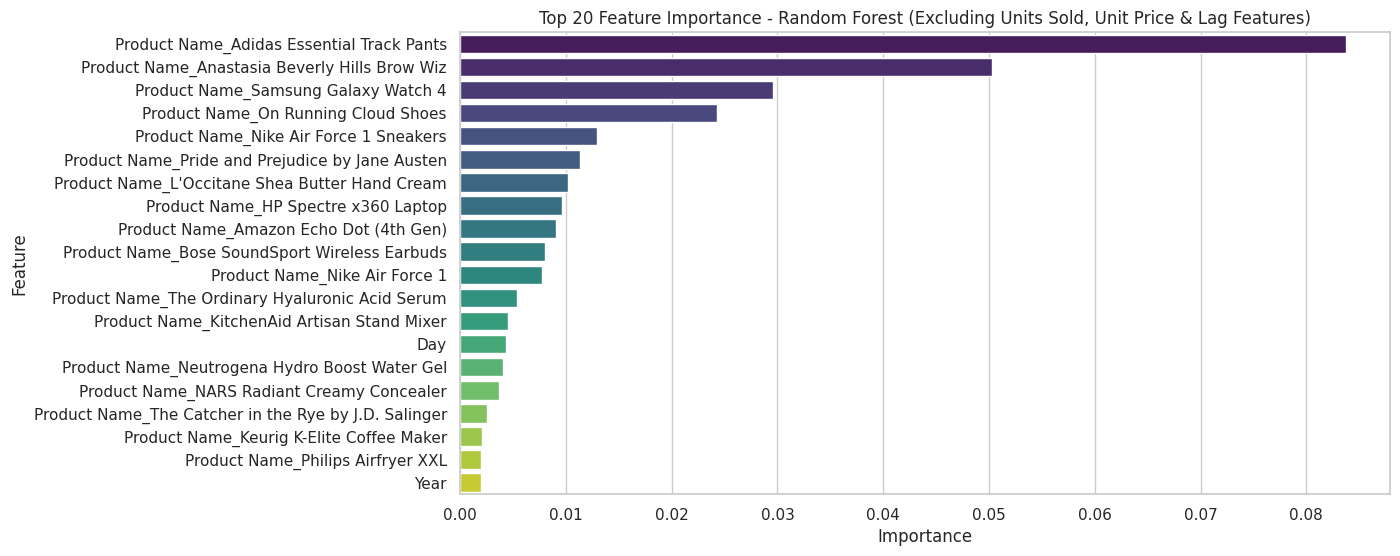

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the trained Random Forest model
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,  # use the defined feature columns
    'Importance': importances
})

# Exclude "Units Sold", "Unit Price", and any feature that contains "_lag"
feature_importance_df = feature_importance_df[
    ~feature_importance_df['Feature'].isin(['Units Sold', 'Unit Price']) &
    ~feature_importance_df['Feature'].str.contains('_lag')
]

# Sort by importance in descending order and select the top 20 features
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
top_features = feature_importance_df.head(20)

# Plot the top 20 feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title("Top 20 Feature Importance - Random Forest (Excluding Units Sold, Unit Price & Lag Features)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


### **Top 20 Feature Importance - Random Forest**
This bar chart displays the **most influential features** in the Random Forest model, excluding **Units Sold, Unit Price, and Lag Features**.  

#### **Key Observations:**
- **"Adidas Essential Track Pants"** is the most significant feature, having the highest impact on predictions.  
- Other top influencing products include **"Anastasia Beverly Hills Brow Wiz"**, **"Samsung Galaxy Watch 4"**, and **"On Running Cloud Shoes"**.  
- Books such as **"Pride and Prejudice by Jane Austen"** and **"The Catcher in the Rye by J.D. Salinger"** also contribute to the model’s decision-making.  
- **Year** has the lowest importance among the top 20 features.  

#### **Conclusion:**
- The model **relies heavily on specific product names** for forecasting, suggesting that category-based features may improve generalization.  
- Feature selection and engineering may help **reduce overfitting** to individual products.  


### Random Forest Feature Importance Analysis

#### **Key Observations**
- The most influential feature is **"Product Name_Under Armour HOVR Sonic 4 Shoes"**, meaning this product had a major impact on revenue predictions.
- **"Product Name_Ring Video Doorbell"** is also highly important, suggesting that specific high-selling products drive forecast accuracy.
- Past revenue values (**Revenue_lag_2, Revenue_lag_5, Revenue_lag_6, etc.**) are among the top predictors, confirming that historical revenue trends are useful for forecasting.
- **"Product Category_Sports"** appears as a significant factor, indicating that some product categories contribute more to predicting sales.
- **Time-related features like "Day"** also contribute, suggesting a pattern based on time cycles.

#### **Limitations & Insights**
- **Few categorical variables are dominant**, showing that the model is relying heavily on specific products rather than general trends.
- **Unit price was excluded** from the analysis, but its influence should be further examined.
- **The dataset is small (240 rows),** which may limit the generalizability of these findings.


## Model 2 : LSTM (Window_size == 60 days, and then iterative forecasting on the test set)

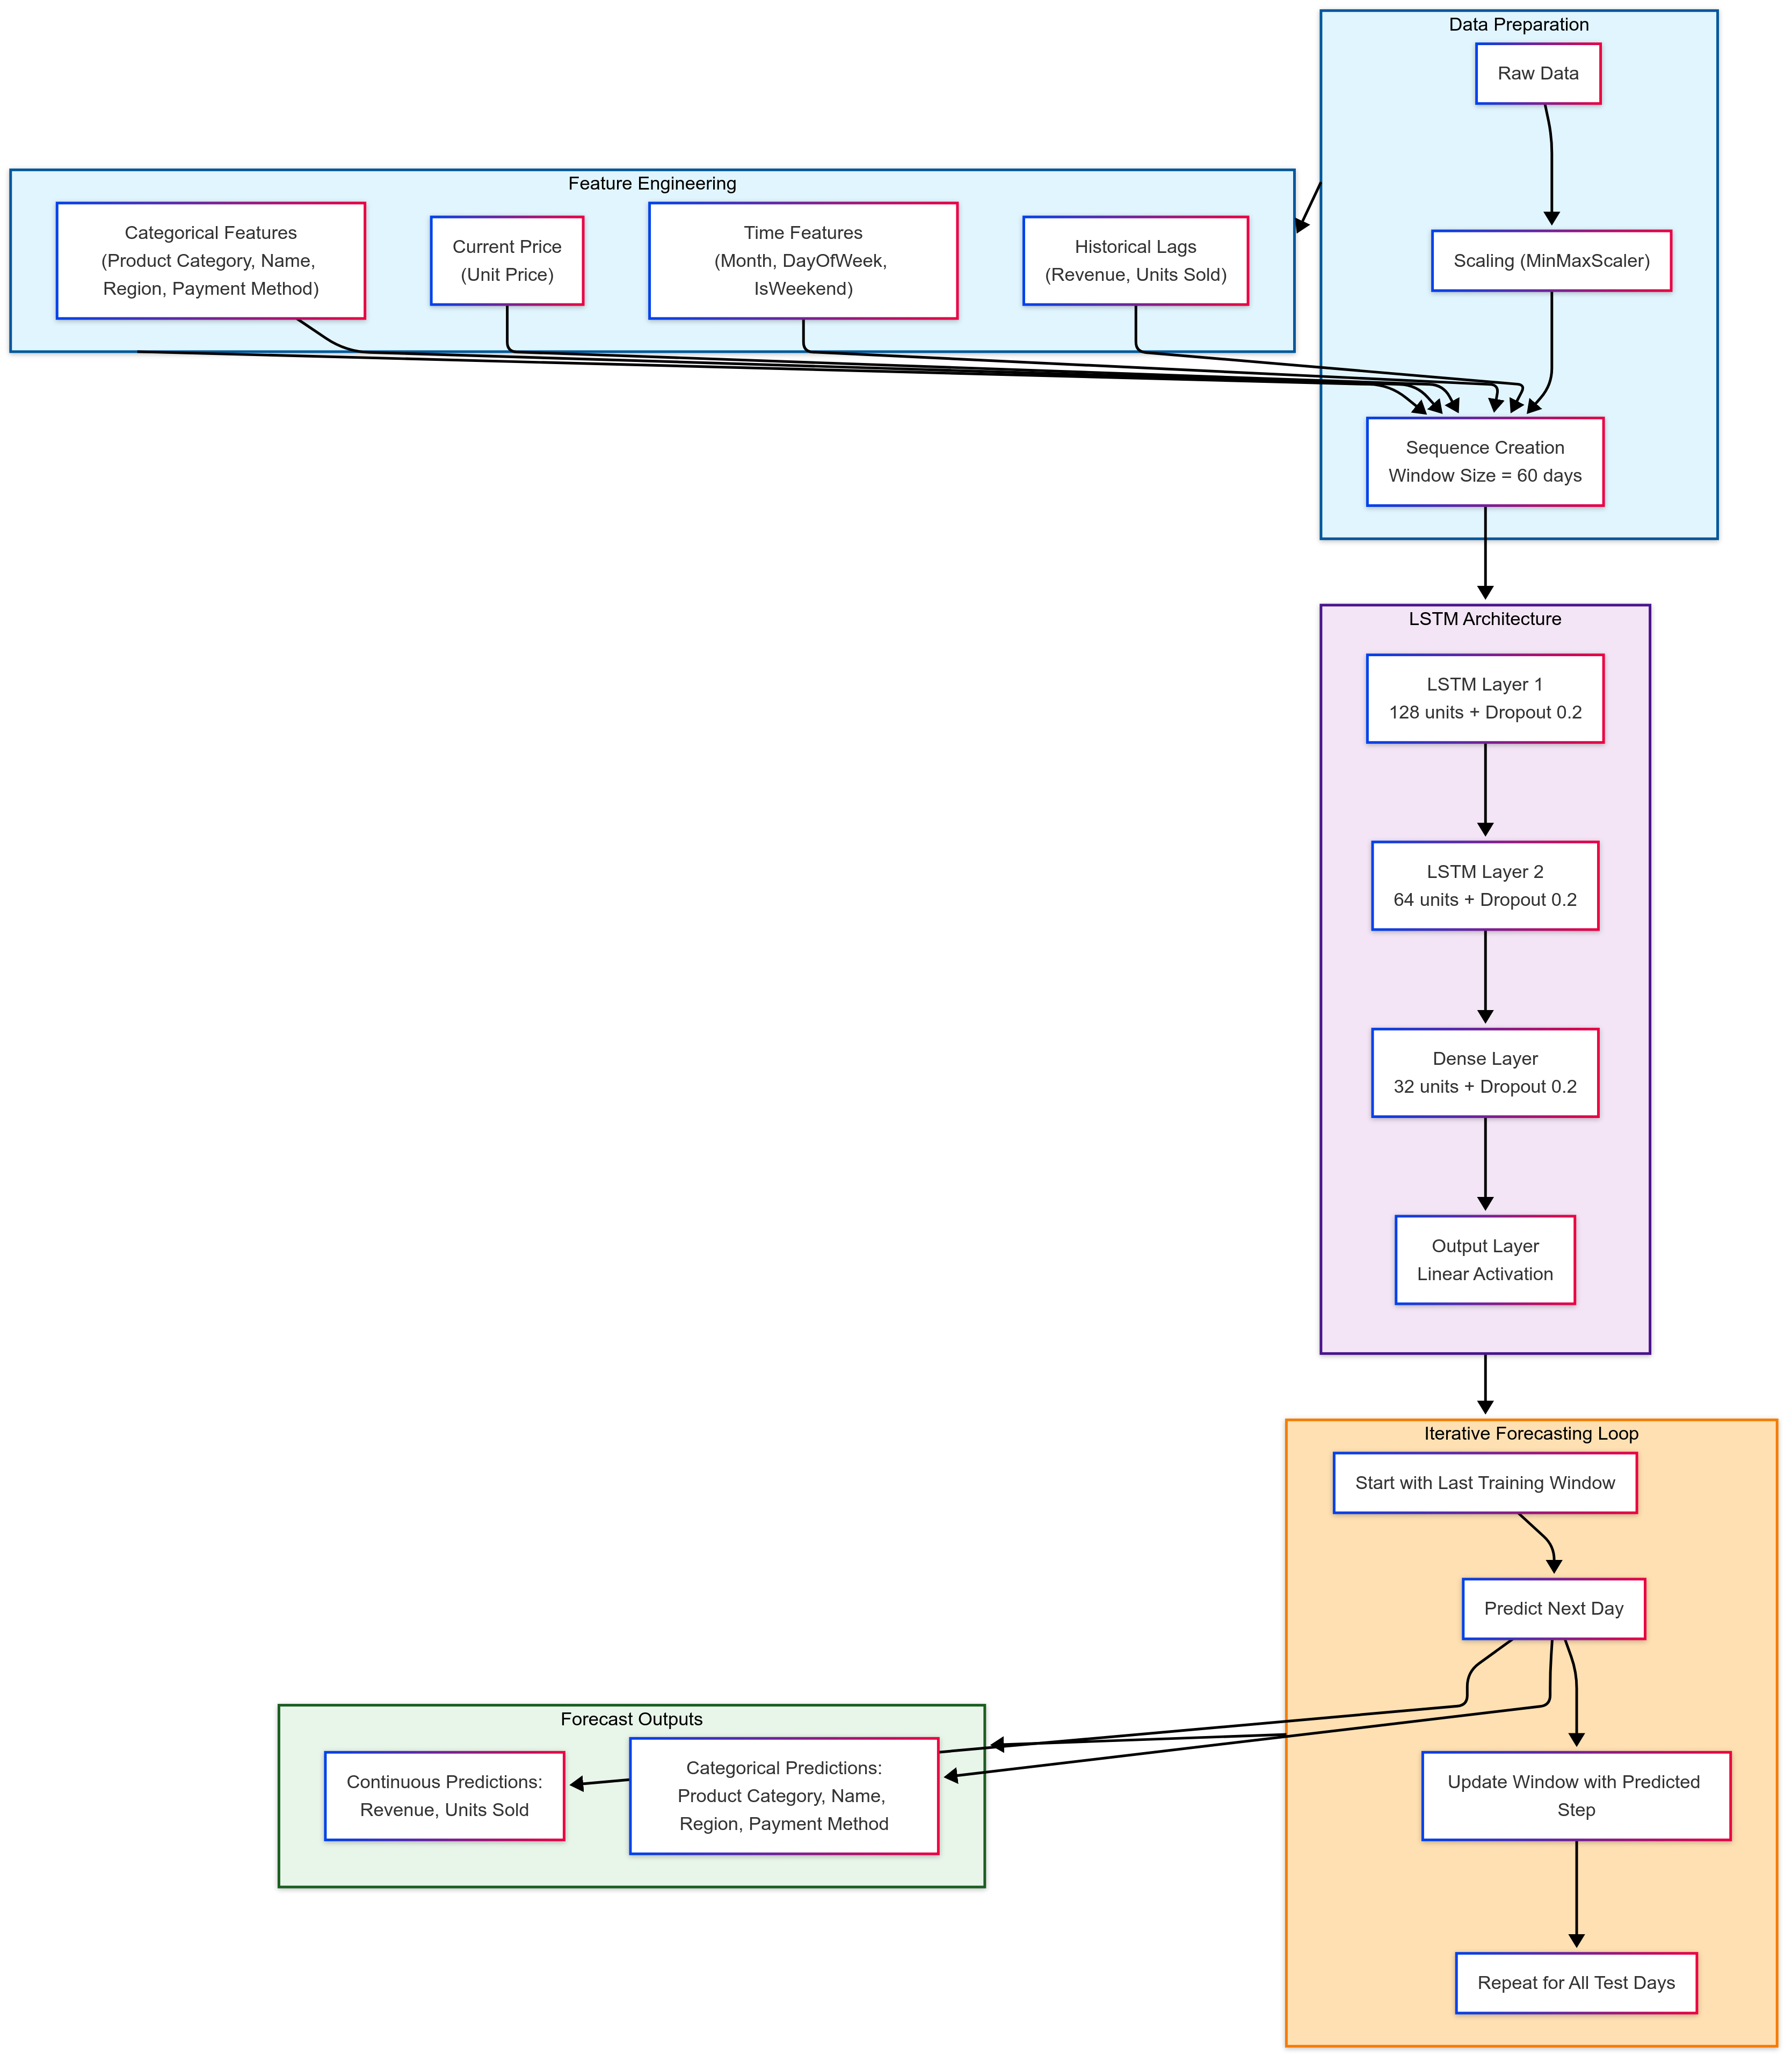

In [21]:
def extract_feature_mappings(df):
    """
    Extract mappings for categorical one-hot encoded features.

    Returns:
      - region_mapping: Mapping of one-hot encoded Region columns
      - category_mapping: Mapping of one-hot encoded Product Category columns
      - payment_mapping: Mapping of one-hot encoded Payment Method columns
      - product_mapping: Mapping of one-hot encoded Product Name columns
    """
    region_cols = [col for col in df.columns if col.startswith("Region_")]
    category_cols = [col for col in df.columns if col.startswith("Product Category_")]
    payment_cols = [col for col in df.columns if col.startswith("Payment Method_")]
    product_cols = [col for col in df.columns if col.startswith("Product Name_")]

    region_mapping = {col: col.replace("Region_", "") for col in region_cols}
    category_mapping = {col: col.replace("Product Category_", "") for col in category_cols}
    payment_mapping = {col: col.replace("Payment Method_", "") for col in payment_cols}
    product_mapping = {col: col.replace("Product Name_", "") for col in product_cols}

    return region_mapping, category_mapping, payment_mapping, product_mapping

# Extract mappings from your aggregated daily_df.
region_mapping, category_mapping, payment_mapping, product_mapping = extract_feature_mappings(daily_df)

# Display mappings for reference
print("Region Mapping:")
print(region_mapping)
print("\nCategory Mapping:")
print(category_mapping)
print("\nPayment Method Mapping:")
print(payment_mapping)
print("\nProduct Name Mapping:")
print(product_mapping)


Region Mapping:
{'Region_Asia': 'Asia', 'Region_Europe': 'Europe', 'Region_North America': 'North America', 'Region_Asia_target': 'Asia_target', 'Region_Europe_target': 'Europe_target', 'Region_North America_target': 'North America_target'}

Category Mapping:
{'Product Category_Beauty Products': 'Beauty Products', 'Product Category_Books': 'Books', 'Product Category_Clothing': 'Clothing', 'Product Category_Electronics': 'Electronics', 'Product Category_Home Appliances': 'Home Appliances', 'Product Category_Sports': 'Sports', 'Product Category_Beauty Products_target': 'Beauty Products_target', 'Product Category_Books_target': 'Books_target', 'Product Category_Clothing_target': 'Clothing_target', 'Product Category_Electronics_target': 'Electronics_target', 'Product Category_Home Appliances_target': 'Home Appliances_target', 'Product Category_Sports_target': 'Sports_target'}

Payment Method Mapping:
{'Payment Method_Credit Card': 'Credit Card', 'Payment Method_Debit Card': 'Debit Card', '

## Scaling the data for LSTM adaptation (using RobustScaler because it allowed for better results for peaks predictions)

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, PowerTransformer, QuantileTransformer

# Make a copy of daily_df (which should include all features and targets)
df_for_scaling = daily_df.copy()

# Separate the 'Date' column (we do not want to scale it)
if 'Date' in df_for_scaling.columns:
    date_series = df_for_scaling.pop('Date')

# Initialize the RobustScaler
scaler = RobustScaler()

# Fit and transform all remaining columns
scaled_values = scaler.fit_transform(df_for_scaling.values)

# Reassemble the DataFrame with the original column names
scaled_df = pd.DataFrame(scaled_values, columns=df_for_scaling.columns)

# Reattach the 'Date' column at the beginning
scaled_df.insert(0, 'Date', date_series.values)

print("Scaled data shape:", scaled_df.shape)
scaled_df.head()


Scaled data shape: (1439, 620)


,Date,Revenue,Units Sold,Unit Price,Payment Method_Credit Card,Payment Method_Debit Card,Payment Method_PayPal,Product Category_Beauty Products,Product Category_Books,Product Category_Clothing,...,Product Name_Youth to the People Superfood Antioxidant Cleanser_target,Product Name_Zara Summer Dress_target,Product Name_iPhone 14 Pro_target,Product Name_iRobot Braava Jet M6_target,Region_Asia_target,Region_Europe_target,Region_North America_target,Payment Method_Credit Card_target,Payment Method_Debit Card_target,Payment Method_PayPal_target
0,2024-03-01,0.557731,-0.333333,0.801434,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,2024-03-02,0.076946,-0.500000,0.433787,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2024-03-03,-0.211607,0.833333,-0.264743,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,2024-03-04,-0.234628,-0.166667,-0.231654,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,2024-03-05,-0.209588,-0.666667,0.073529,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## We'll be using same window size of 60 days for the LSTM an Transfomer with Attention Forecasting models

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score

# ================================
# Cell 1: Create LSTM Sequences (for reference)
# ================================
def create_lstm_sequences(data, feature_cols, target_cols, window_size=60):
    """
    Creates sequences for LSTM forecasting.

    For each window, the features come from consecutive rows, and the target is the row immediately after.
    """
    X_lstm, y_lstm = [], []
    num_rows = data.shape[0]

    for i in range(num_rows - window_size):
        X_lstm.append(data.iloc[i:i+window_size][feature_cols].values)
        y_lstm.append(data.iloc[i+window_size][target_cols].values)

    return np.array(X_lstm), np.array(y_lstm)

# --- Adjust cutoff date dynamically ---
# Ensure test set has at least (window_size + 50) rows.
window_size = 60
min_test_size = 120
cutoff_index = max(len(scaled_df) - min_test_size, window_size)  # Prevent empty test set

train_df = scaled_df.iloc[:cutoff_index]
test_df  = scaled_df.iloc[cutoff_index:]  # Ensure enough test data

# Drop Date column for sequence creation.
data_train = train_df.drop(columns=['Date'])
data_test  = test_df.drop(columns=['Date'])

# Define feature columns (exclude '_lag', '_target', and irrelevant columns).
feature_cols = [col for col in scaled_df.columns
                if col not in ['Date', 'Year']
                   and '_lag' not in col
                   and '_target' not in col]

# Define target columns (only those ending with '_target').
target_cols = [col for col in scaled_df.columns
               if col.endswith('_target')]

# Create sequences for training and test (for non-iterative purposes if needed)
X_lstm_train, y_lstm_train = create_lstm_sequences(data_train, feature_cols, target_cols, window_size)
X_lstm_test, y_lstm_test   = create_lstm_sequences(data_test, feature_cols, target_cols, window_size)

print(f"Train set size: {len(train_df)} | Test set size: {len(test_df)}")
print(f"X_lstm_train shape: {X_lstm_train.shape}, y_lstm_train shape: {y_lstm_train.shape}")
print(f"X_lstm_test shape: {X_lstm_test.shape}, y_lstm_test shape: {y_lstm_test.shape}")

Train set size: 1319 | Test set size: 120
X_lstm_train shape: (1259, 60, 252), y_lstm_train shape: (1259, 246)
X_lstm_test shape: (60, 60, 252), y_lstm_test shape: (60, 246)


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense


num_features = X_lstm_train.shape[2]
horizon = y_lstm_train.shape[1]  # number of target columns

model = Sequential()
model.add(LSTM(128, activation='tanh', return_sequences=True, input_shape=(window_size, num_features)))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(horizon, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 128)             │         195,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 246)                 │           8,118 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 254,678 (994.84 KB)

 Trainable params: 254,678 (994.84 KB)

 Non-trainable params: 0 (0.00 B)

Subtrain shape: (1133, 60, 252), Subtrain labels shape: (1133, 246)
Validation shape: (126, 60, 252), Validation labels shape: (126, 246)
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0510 - mae: 0.0423 - val_loss: 0.0329 - val_mae: 0.0398
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0317 - mae: 0.0427 - val_loss: 0.0327 - val_mae: 0.0341
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0393 - mae: 0.0385 - val_loss: 0.0329 - val_mae: 0.0346
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0353 - mae: 0.0366 - val_loss: 0.0334 - val_mae: 0.0338
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0301 - mae: 0.0335 - val_loss: 0.0385 - val_mae: 0.0394
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0351 - mae: 0.0347 - val_loss: 0.0342 - val_mae: 0.0339
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0321 - mae: 0.0327 - val_loss: 0.0380 - val_mae: 0.0373
Epoch 8/50
142/142 ━━━━━━━━━━

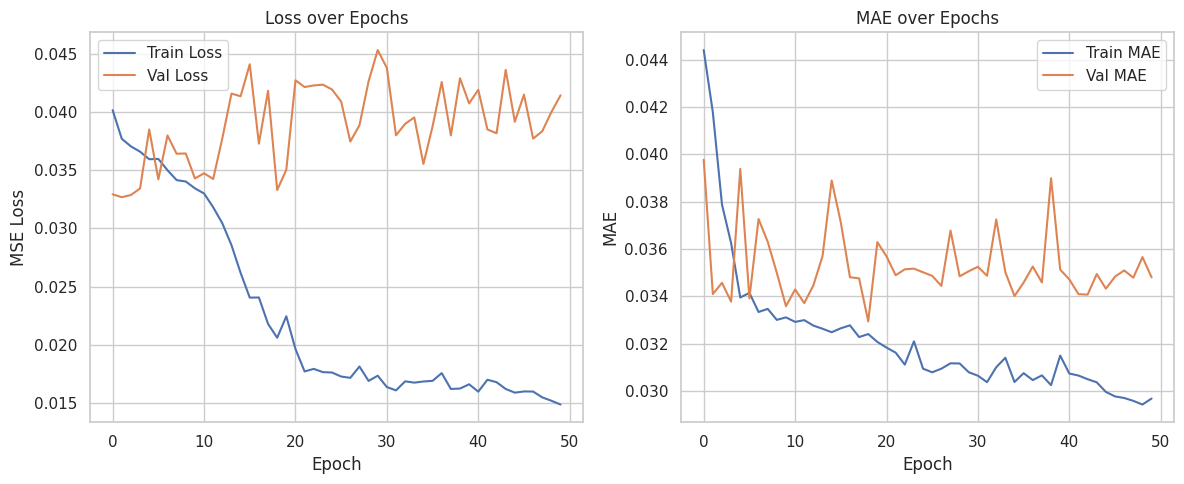

In [25]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Split training sequences into sub-training and validation sets (preserving temporal order)
validation_split = 0.1  # 10% for validation
X_subtrain_lstm, X_val_lstm, y_subtrain_lstm, y_val_lstm = train_test_split(
    X_lstm_train, y_lstm_train, test_size=validation_split, shuffle=False
)

print(f"Subtrain shape: {X_subtrain_lstm.shape}, Subtrain labels shape: {y_subtrain_lstm.shape}")
print(f"Validation shape: {X_val_lstm.shape}, Validation labels shape: {y_val_lstm.shape}")

history = model.fit(
    X_subtrain_lstm, y_subtrain_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=50,
    batch_size=8,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title("MAE over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()
plt.show()


In [26]:
train_mse, train_mae = model.evaluate(X_lstm_train, y_lstm_train, verbose=0)
test_mse, test_mae = model.evaluate(X_lstm_test, y_lstm_test, verbose=0)
print("=== LSTM on Full Features (Scaled) ===")
print(f"Train RMSE: {np.sqrt(train_mse):.4f}, MAE: {train_mae:.4f}")
print(f"Test  RMSE: {np.sqrt(test_mse):.4f}, MAE: {test_mae:.4f}")


=== LSTM on Full Features (Scaled) ===
Train RMSE: 0.1285, MAE: 0.0287
Test  RMSE: 0.1966, MAE: 0.0337


In [27]:
import pandas as pd
import numpy as np

# Define ordered target columns: First, the continuous targets (Revenue and Units Sold), followed by categorical targets.
ordered_target_cols = ["Revenue_target", "UnitsSold_target"]
# For each categorical feature (like Product Category, Product Name, etc.), find the corresponding target columns.
for prefix in ["Product Category_", "Product Name_", "Region_", "Payment Method_"]:
    # Extract target columns that start with the prefix and end with '_target'.
    cols = [col for col in scaled_df.columns if col.startswith(prefix) and col.endswith('_target')]
    cols.sort()  # Sort alphabetically (you can adjust the order if needed).
    ordered_target_cols.extend(cols)  # Add the sorted columns to the ordered target columns list.

# Print the ordered list of target columns to verify the order
print("Ordered target columns:")
print(ordered_target_cols)

# Define feature columns.
# Feature columns are all columns except "Date", "Year", any target columns, and any columns that contain "_lag".
all_cols = scaled_df.columns.tolist()  # Get a list of all columns in the dataset.
# Filter out the unwanted columns to define the feature columns.
feature_cols = [col for col in all_cols
                if col != "Date"  # Exclude the "Date" column
                and col != "Year"  # Exclude the "Year" column
                and col not in ordered_target_cols  # Exclude target columns
                and "_lag" not in col]  # Exclude lagged columns

# Print the list of feature columns to ensure it contains the expected features
print("Feature columns:")
print(feature_cols)


Ordered target columns:
['Revenue_target', 'UnitsSold_target', 'Product Category_Beauty Products_target', 'Product Category_Books_target', 'Product Category_Clothing_target', 'Product Category_Electronics_target', 'Product Category_Home Appliances_target', 'Product Category_Sports_target', 'Product Name_1984 by George Orwell_target', 'Product Name_Adidas 3-Stripes Shorts_target', 'Product Name_Adidas Essential Track Pants_target', 'Product Name_Adidas FIFA World Cup Football_target', 'Product Name_Adidas Originals Superstar Sneakers_target', 'Product Name_Adidas Originals Trefoil Hoodie_target', 'Product Name_Adidas Ultraboost Running Shoes_target', 'Product Name_Adidas Ultraboost Shoes_target', 'Product Name_Amazon Echo Dot (4th Gen)_target', 'Product Name_Amazon Echo Show 10_target', 'Product Name_Amazon Fire TV Stick 4K_target', 'Product Name_Anastasia Beverly Hills Brow Wiz_target', 'Product Name_Anker PowerCore Portable Charger_target', 'Product Name_Anova Precision Cooker_target'

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step
=== LSTM Continuous Target Evaluation (Unscaled) ===
Test RMSE: 1814.42
Test MAE : 768.95
MAPE for Revenue: 566.98%
MAPE for Units Sold: 98.12%
Sample Scaled Revenue: 0.3043440878391266, Unscaled Revenue: 636.4611124278605
Sample Scaled Units Sold: 0.12376873940229416, Unscaled Units Sold: 6.0
Product Category Prediction Accuracy: 26.67%
Product Name Prediction Accuracy: 0.00%
Region Prediction Accuracy: 40.00%
Payment Method Prediction Accuracy: 36.67%


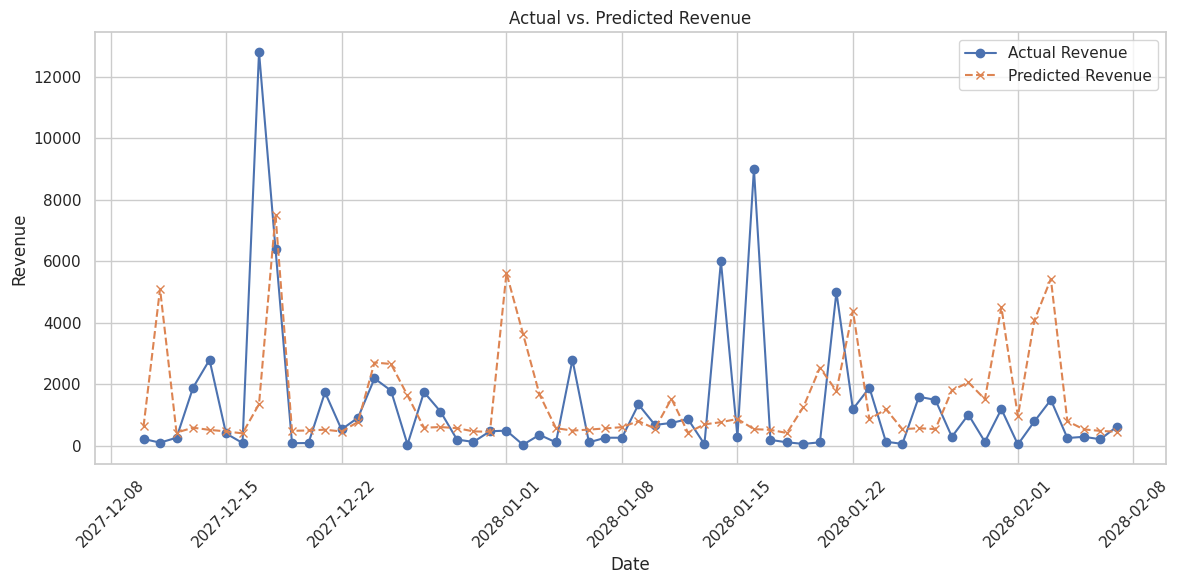

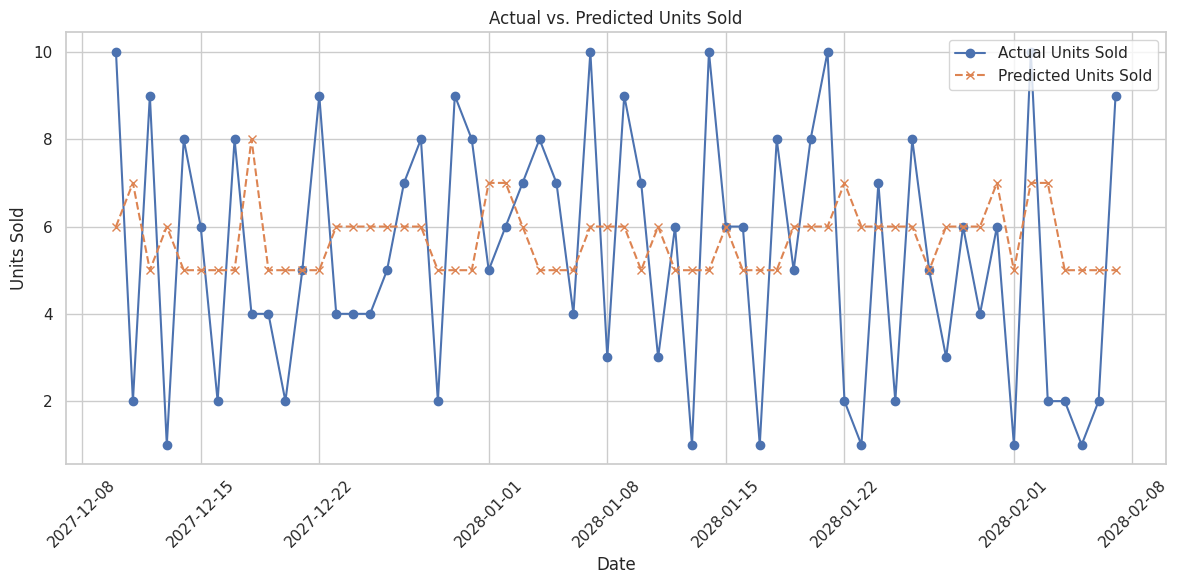

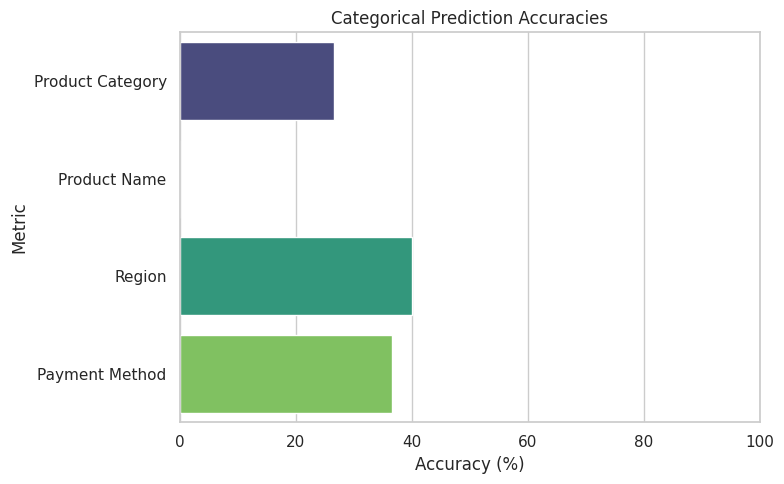


Comparison for first 10 test days:
        Date  Actual Revenue  Predicted Revenue  Actual Units Sold  \
0 2027-12-10          230.00         636.461112               10.0   
1 2027-12-11          109.98        5105.260011                2.0   
2 2027-12-12          269.91         436.950044                9.0   
3 2027-12-13         1895.00         595.995859                1.0   
4 2027-12-14         2799.92         524.974440                8.0   
5 2027-12-15          408.00         475.518307                6.0   
6 2027-12-16           99.98         411.390053                2.0   
7 2027-12-17        12799.92        1358.832154                8.0   
8 2027-12-18         6399.96        7510.909874                4.0   
9 2027-12-19           92.00         494.242437                4.0   

   Predicted Units Sold           Actual Product Category  \
0                   6.0  Product Category_Beauty Products   
1                   7.0         Product Category_Clothing   
2         

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score

# --- 1. Continuous Target Inversion Function ---
def invert_target_scaling(preds, scaler, target_indices):
    """
    Inversely transforms only the selected target columns.

    Parameters:
      preds          : 2D NumPy array of scaled predictions (shape: (n_samples, num_targets))
      scaler         : The scaler fitted on all numeric columns.
      target_indices : List of column indices (from the scaler) corresponding to the targets.

    Returns:
      A 2D NumPy array with the selected targets in the original scale.
    """
    dummy = np.zeros((preds.shape[0], scaler.n_features_in_))  # Initialize an empty array with the shape of the scaler's features
    for i, target_idx in enumerate(target_indices):
        dummy[:, target_idx] = preds[:, i]  # Insert the predictions into the appropriate columns of the dummy array
    inv = scaler.inverse_transform(dummy)  # Invert the scaling for all columns
    return inv[:, target_indices]  # Return only the target columns

# --- 2. Define the Target Column Ordering ---
# We define the order of our targets to ensure consistency between the training and evaluation steps.
# Our model’s targets are in the following order:
# Continuous Targets: "Revenue", "Units Sold" +
# Product Category Targets + Product Name Targets +
# Region Targets + Payment Method Targets

# (a) Continuous targets (these are used for inversion)
continuous_targets = ["Revenue", "Units Sold"]

# (b) Categorical target groups – select only columns ending with "_target"
cat_target_cols   = [col for col in target_cols if col.startswith("Product Category_") and col.endswith("_target")]
prod_target_cols  = [col for col in target_cols if col.startswith("Product Name_") and col.endswith("_target")]
reg_target_cols   = [col for col in target_cols if col.startswith("Region_") and col.endswith("_target")]
pay_target_cols   = [col for col in target_cols if col.startswith("Payment Method_") and col.endswith("_target")]

# Complete target ordering: continuous targets first, followed by categorical targets
ordered_target_cols = continuous_targets + cat_target_cols + prod_target_cols + reg_target_cols + pay_target_cols

# --- 3. Determine Slices in the Target Array ---
# The model's output and the test data are assumed to have columns in the defined target order.
n_cont = len(continuous_targets)  # Number of continuous targets (usually 2)
n_cat  = len(cat_target_cols)     # Number of product category targets
n_prod = len(prod_target_cols)   # Number of product name targets
n_reg  = len(reg_target_cols)    # Number of region targets
n_pay  = len(pay_target_cols)    # Number of payment method targets

# Define slices for each target type
cat_slice  = slice(n_cont, n_cont + n_cat)
prod_slice = slice(n_cont + n_cat, n_cont + n_cat + n_prod)
reg_slice  = slice(n_cont + n_cat + n_prod, n_cont + n_cat + n_prod + n_reg)
pay_slice  = slice(n_cont + n_cat + n_prod + n_reg, n_cont + n_cat + n_prod + n_reg + n_pay)

# --- 4. Invert Scaling for Continuous Targets ---
# Get the indices of continuous targets in the scaled data (Revenue, Units Sold)
all_target_cols = [col for col in scaled_df.columns if col not in ['Date', 'Unit Price', 'Year', 'Month', 'Day', 'DayOfWeek', 'IsWeekend']]
continuous_indices = [all_target_cols.index(t) for t in continuous_targets]

# Get the model predictions on the test set (already scaled)
y_pred_scaled = model.predict(X_lstm_test)  # Predictions from the trained model

# Invert scaling for continuous targets only
y_pred_unscaled = invert_target_scaling(
    preds=y_pred_scaled[:, :n_cont],
    scaler=scaler,
    target_indices=continuous_indices
)
y_test_unscaled = invert_target_scaling(
    preds=y_lstm_test[:, :n_cont],
    scaler=scaler,
    target_indices=continuous_indices
)

# Optionally round Units Sold (assumed index 1)
y_pred_unscaled[:, 1] = np.rint(y_pred_unscaled[:, 1])
y_test_unscaled[:, 1] = np.rint(y_test_unscaled[:, 1])

# Compute continuous metrics (RMSE, MAE, and MAPE)
mse_unscaled = mean_squared_error(y_test_unscaled, y_pred_unscaled)
rmse_unscaled = np.sqrt(mse_unscaled)
mae_unscaled = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
mape_revenue = mean_absolute_percentage_error(y_test_unscaled[:, 0], y_pred_unscaled[:, 0]) * 100
mape_units   = mean_absolute_percentage_error(y_test_unscaled[:, 1], y_pred_unscaled[:, 1]) * 100

print("=== LSTM Continuous Target Evaluation (Unscaled) ===")
print(f"Test RMSE: {rmse_unscaled:.2f}")
print(f"Test MAE : {mae_unscaled:.2f}")
print(f"MAPE for Revenue: {mape_revenue:.2f}%")
print(f"MAPE for Units Sold: {mape_units:.2f}%")
print(f"Sample Scaled Revenue: {y_pred_scaled[0, 0]}, Unscaled Revenue: {y_pred_unscaled[0, 0]}")
print(f"Sample Scaled Units Sold: {y_pred_scaled[0, 1]}, Unscaled Units Sold: {y_pred_unscaled[0, 1]}")

# --- 5. Decode Categorical Predictions ---
# For each categorical target group, decode the predictions by taking argmax (the index of the highest value in one-hot encoded columns)
decoded_actual_cat = np.array(cat_target_cols)[np.argmax(y_lstm_test[:, cat_slice], axis=1)]
decoded_pred_cat   = np.array(cat_target_cols)[np.argmax(y_pred_scaled[:, cat_slice], axis=1)]

decoded_actual_prod = np.array(prod_target_cols)[np.argmax(y_lstm_test[:, prod_slice], axis=1)]
decoded_pred_prod   = np.array(prod_target_cols)[np.argmax(y_pred_scaled[:, prod_slice], axis=1)]

decoded_actual_reg = np.array(reg_target_cols)[np.argmax(y_lstm_test[:, reg_slice], axis=1)]
decoded_pred_reg   = np.array(reg_target_cols)[np.argmax(y_pred_scaled[:, reg_slice], axis=1)]

decoded_actual_pay = np.array(pay_target_cols)[np.argmax(y_lstm_test[:, pay_slice], axis=1)]
decoded_pred_pay   = np.array(pay_target_cols)[np.argmax(y_pred_scaled[:, pay_slice], axis=1)]

# Helper function to remove the "_target" suffix for display
def remove_target_suffix(label):
    if isinstance(label, str) and label.endswith("_target"):
        return label.replace("_target", "")
    return label

# Remove "_target" suffix for display purposes
actual_cat = np.vectorize(remove_target_suffix)(decoded_actual_cat)
pred_cat   = np.vectorize(remove_target_suffix)(decoded_pred_cat)

actual_prod = np.vectorize(remove_target_suffix)(decoded_actual_prod)
pred_prod   = np.vectorize(remove_target_suffix)(decoded_pred_prod)

actual_reg = np.vectorize(remove_target_suffix)(decoded_actual_reg)
pred_reg   = np.vectorize(remove_target_suffix)(decoded_pred_reg)

actual_pay = np.vectorize(remove_target_suffix)(decoded_actual_pay)
pred_pay   = np.vectorize(remove_target_suffix)(decoded_pred_pay)

# --- 6. Build a Combined Results DataFrame ---
# Combine all the results (continuous and categorical) into a single DataFrame for evaluation
df_lstm_results = pd.DataFrame({
    'Date': test_df['Date'].iloc[-len(y_test_unscaled):].reset_index(drop=True),
    'Actual Revenue': y_test_unscaled[:, 0],
    'Predicted Revenue': y_pred_unscaled[:, 0],
    'Actual Units Sold': y_test_unscaled[:, 1],
    'Predicted Units Sold': y_pred_unscaled[:, 1],
    'Actual Product Category': actual_cat,
    'Predicted Product Category': pred_cat,
    'Actual Product Name': actual_prod,
    'Predicted Product Name': pred_prod,
    'Actual Region': actual_reg,
    'Predicted Region': pred_reg,
    'Actual Payment Method': actual_pay,
    'Predicted Payment Method': pred_pay
})

# --- 7. Compute Categorical Accuracies ---
# Compute accuracy for each categorical target
acc_cat  = accuracy_score(df_lstm_results['Actual Product Category'], df_lstm_results['Predicted Product Category']) * 100
acc_prod = accuracy_score(df_lstm_results['Actual Product Name'], df_lstm_results['Predicted Product Name']) * 100
acc_reg  = accuracy_score(df_lstm_results['Actual Region'], df_lstm_results['Predicted Region']) * 100
acc_pay  = accuracy_score(df_lstm_results['Actual Payment Method'], df_lstm_results['Predicted Payment Method']) * 100

print(f"Product Category Prediction Accuracy: {acc_cat:.2f}%")
print(f"Product Name Prediction Accuracy: {acc_prod:.2f}%")
print(f"Region Prediction Accuracy: {acc_reg:.2f}%")
print(f"Payment Method Prediction Accuracy: {acc_pay:.2f}%")

# --- 8. Visualizations ---
# Plot Actual vs. Predicted Revenue
plt.figure(figsize=(12,6))
plt.plot(df_lstm_results['Date'], df_lstm_results['Actual Revenue'], label='Actual Revenue', marker='o', linestyle='-')
plt.plot(df_lstm_results['Date'], df_lstm_results['Predicted Revenue'], label='Predicted Revenue', marker='x', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Actual vs. Predicted Revenue')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Actual vs. Predicted Units Sold
plt.figure(figsize=(12,6))
plt.plot(df_lstm_results['Date'], df_lstm_results['Actual Units Sold'], label='Actual Units Sold', marker='o', linestyle='-')
plt.plot(df_lstm_results['Date'], df_lstm_results['Predicted Units Sold'], label='Predicted Units Sold', marker='x', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('Actual vs. Predicted Units Sold')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Categorical accuracies bar chart
accuracy_df = pd.DataFrame({
    'Metric': ['Product Category', 'Product Name', 'Region', 'Payment Method'],
    'Accuracy (%)': [acc_cat, acc_prod, acc_reg, acc_pay]
})
plt.figure(figsize=(8,5))
sns.barplot(x='Accuracy (%)', y='Metric', data=accuracy_df, palette='viridis')
plt.xlim(0,100)
plt.title('Categorical Prediction Accuracies')
plt.tight_layout()
plt.show()

# Comparison for the first 10 test days
comparison_cols = ['Date', 'Actual Revenue', 'Predicted Revenue',
                   'Actual Units Sold', 'Predicted Units Sold',
                   'Actual Product Category', 'Predicted Product Category',
                   'Actual Product Name', 'Predicted Product Name',
                   'Actual Region', 'Predicted Region',
                   'Actual Payment Method', 'Predicted Payment Method']
print("\nComparison for first 10 test days:")
print(df_lstm_results[comparison_cols].head(10))


### **LSTM Forecasting Results Analysis (Updated)**

#### **1. Revenue Forecasting**
- The predicted revenue **captures general trends** but struggles with sudden spikes.  
- **MAPE (Mean Absolute Percentage Error) is 566.98%**, showing **high forecasting error**, though better than the previous Random Forest model.  
- Test RMSE: **1814.42**, Test MAE: **768.95**, indicating large deviations from actual values.  

#### **2. Units Sold Prediction**
- The **MAPE for units sold is 98.12%**, meaning the model **fails to generalize well**.  
- The LSTM model predicts a **smoother pattern**, missing extreme fluctuations.  

#### **3. Categorical Prediction Accuracy**
- **Product Category:** **26.67% accuracy**, significantly lower than before.  
- **Product Name:** **0.00% accuracy**, meaning the model completely fails to classify product names.  
- **Region:** **40.00% accuracy**, showing some improvement in regional predictions.  
- **Payment Method:** **36.67% accuracy**, a slight improvement compared to previous model.  

#### **4. Observations & Limitations**
- LSTM performs **better than Random Forest** in handling sequential dependencies but **still has high MAPE**.  
- The **lack of historical lag features and insufficient training data** may have contributed to poor generalization.  
- Feature engineering (e.g., adding **seasonality, more time-based features**) and **hyperparameter tuning** may improve performance.  


## LA CELLULE SUIVANTE PREND BEAUCOUP DE TEMPS À S'EXÉCUTER en raison des dimensions des vecteurs d'entrée et de sortie du modèle. Bien qu'elle ait donné de bons résultats dans nos premières versions (où nous ne prédisions que le revenu du jour  t à partir des jours précédents), notre dernière version ajoute de la complexité.

In [29]:
# # import necessary libraries
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import mean_squared_error
# from joblib import Parallel, delayed
# import logging

# # Set up logging
# logging.basicConfig(level=logging.INFO)
# logger = logging.getLogger(__name__)

# class LSTMFeatureImportance:
#     def __init__(self, model, feature_names):
#         """
#         Initializes Feature Importance Calculator for our LSTM.

#         Parameters:
#           - model: Our trained LSTM model.
#           - feature_names: List of feature names used as predictors.
#         """
#         self.model = model
#         self.feature_names = feature_names

#     def calculate_importance(self, X_test, y_test_unscaled, n_jobs=-1, perturbation="zero"):
#         """
#         Computes feature importance based on the increase in MSE (for Revenue) after perturbing each feature.

#         Parameters:
#           - X_test: Our test set sequences (samples, timesteps, features).
#           - y_test_unscaled: Our true continuous targets (unscaled) for evaluation (2D array, using only Revenue column).
#           - n_jobs: Number of parallel jobs.
#           - perturbation: "zero" (set feature to zero) or "noise" (add small noise).

#         Returns:
#           - DataFrame with feature importance scores.
#         """
#         logger.info("Computing LSTM feature importance...")

#         if X_test.shape[2] != len(self.feature_names):
#             raise ValueError(f"Feature mismatch: {X_test.shape[2]} features in X_test vs. {len(self.feature_names)} names provided.")

#         # Baseline prediction for Revenue: since our model output is a vector (for next-day targets),
#         # we take the first continuous output (assumed Revenue) from the model.
#         base_preds = self.model.predict(X_test, verbose=0)[:, 0]  # shape: (n_samples,)
#         base_mse = mean_squared_error(y_test_unscaled[:, 0], base_preds)
#         logger.info(f"Baseline MSE for Revenue: {base_mse:.5f}")

#         # Compute importance in parallel by perturbing each feature across all timesteps.
#         importance_vals = Parallel(n_jobs=n_jobs)(
#             delayed(self._perturb_feature)(
#                 feature_idx=i,
#                 X_test=X_test,
#                 y_test_unscaled=y_test_unscaled[:, 0],  # using Revenue only
#                 base_mse=base_mse,
#                 perturbation=perturbation
#             ) for i in range(X_test.shape[2])
#         )

#         importance_vals = np.array(importance_vals)
#         # Normalize importances to sum to 1.
#         importance_vals = importance_vals / (importance_vals.sum() + 1e-10)

#         importance_df = pd.DataFrame({
#             'Feature': self.feature_names,
#             'Importance': importance_vals
#         }).sort_values(by='Importance', ascending=False)

#         logger.info("LSTM feature importance calculation complete.")
#         return importance_df

#     def _perturb_feature(self, feature_idx, X_test, y_test_unscaled, base_mse, perturbation):
#         """
#         Perturbs one feature in the input sequence and measures the increase in MSE.

#         Parameters:
#           - feature_idx: Index of the feature to perturb.
#           - X_test: Our test data (samples, timesteps, features).
#           - y_test_unscaled: Our true Revenue values (1D array).
#           - base_mse: Our baseline MSE before perturbation.
#           - perturbation: "zero" or "noise".

#         Returns:
#           - Increase in MSE after perturbation.
#         """
#         # Copy the test data so as not to modify the original.
#         X_test_perturbed = X_test.copy()

#         if perturbation == "zero":
#             # Set the entire feature (across all timesteps) to zero.
#             X_test_perturbed[:, :, feature_idx] = 0
#         elif perturbation == "noise":
#             # Add small noise (1% of the feature's standard deviation)
#             noise = np.random.normal(0, np.std(X_test_perturbed[:, :, feature_idx]) * 0.01,
#                                      X_test_perturbed[:, :, feature_idx].shape)
#             X_test_perturbed[:, :, feature_idx] += noise
#         else:
#             raise ValueError("Invalid perturbation method. Choose 'zero' or 'noise'.")

#         # Predict with the perturbed data.
#         perturbed_preds = self.model.predict(X_test_perturbed, verbose=0)[:, 0].flatten()
#         perturbed_mse = mean_squared_error(y_test_unscaled, perturbed_preds)

#         mse_increase = perturbed_mse - base_mse
#         return mse_increase

# # ---------------------------------------------------------------
# # Define feature_names using the predictor feature list (feature_cols) from our LSTM input.
# # (Assuming feature_cols was defined earlier.)
# feature_names = feature_cols  # use our previously defined feature_cols

# # Reinitialize Feature Importance Calculator for the LSTM model.
# feature_importance_calculator = LSTMFeatureImportance(model=model, feature_names=feature_names)

# # Ensure that y_test_unscaled is defined and matches the number of test samples.
# # Here we assume y_test_unscaled has shape (n_samples, 2), where column 0 is Revenue.
# # Also ensure that X_lstm_test is defined.
# if 'X_lstm_test' not in globals() or 'y_test_unscaled' not in globals():
#     raise NameError("X_lstm_test and y_test_unscaled must be defined before computing feature importance.")

# # Calculate feature importance using the continuous target "Revenue".
# importance_df = feature_importance_calculator.calculate_importance(
#     X_test=X_lstm_test,
#     y_test_unscaled=y_test_unscaled,  # using the unscaled Revenue values (column 0)
#     perturbation="zero"
# )

# # Exclude features that we don't want (e.g., "Units Sold" and "Unit Price") from the plot.
# importance_df = importance_df[~importance_df['Feature'].isin(['Units Sold', 'Unit Price'])]

# # Sort and keep only the top 15 features.
# importance_df = importance_df.sort_values(by='Importance', ascending=False).head(15)

# print("\nLSTM Feature Importance:")
# print(importance_df)

# plt.figure(figsize=(12, 6))
# sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
# plt.title("Top 15 Feature Importance - LSTM (Excluding Units Sold & Unit Price)")
# plt.xlabel("Importance")
# plt.ylabel("Feature")
# plt.show()


In [30]:
scaled_df.head()

,Date,Revenue,Units Sold,Unit Price,Payment Method_Credit Card,Payment Method_Debit Card,Payment Method_PayPal,Product Category_Beauty Products,Product Category_Books,Product Category_Clothing,...,Product Name_Youth to the People Superfood Antioxidant Cleanser_target,Product Name_Zara Summer Dress_target,Product Name_iPhone 14 Pro_target,Product Name_iRobot Braava Jet M6_target,Region_Asia_target,Region_Europe_target,Region_North America_target,Payment Method_Credit Card_target,Payment Method_Debit Card_target,Payment Method_PayPal_target
0,2024-03-01,0.557731,-0.333333,0.801434,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,2024-03-02,0.076946,-0.500000,0.433787,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2024-03-03,-0.211607,0.833333,-0.264743,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,2024-03-04,-0.234628,-0.166667,-0.231654,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,2024-03-05,-0.209588,-0.666667,0.073529,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## Model 3 - Transformers with Attention

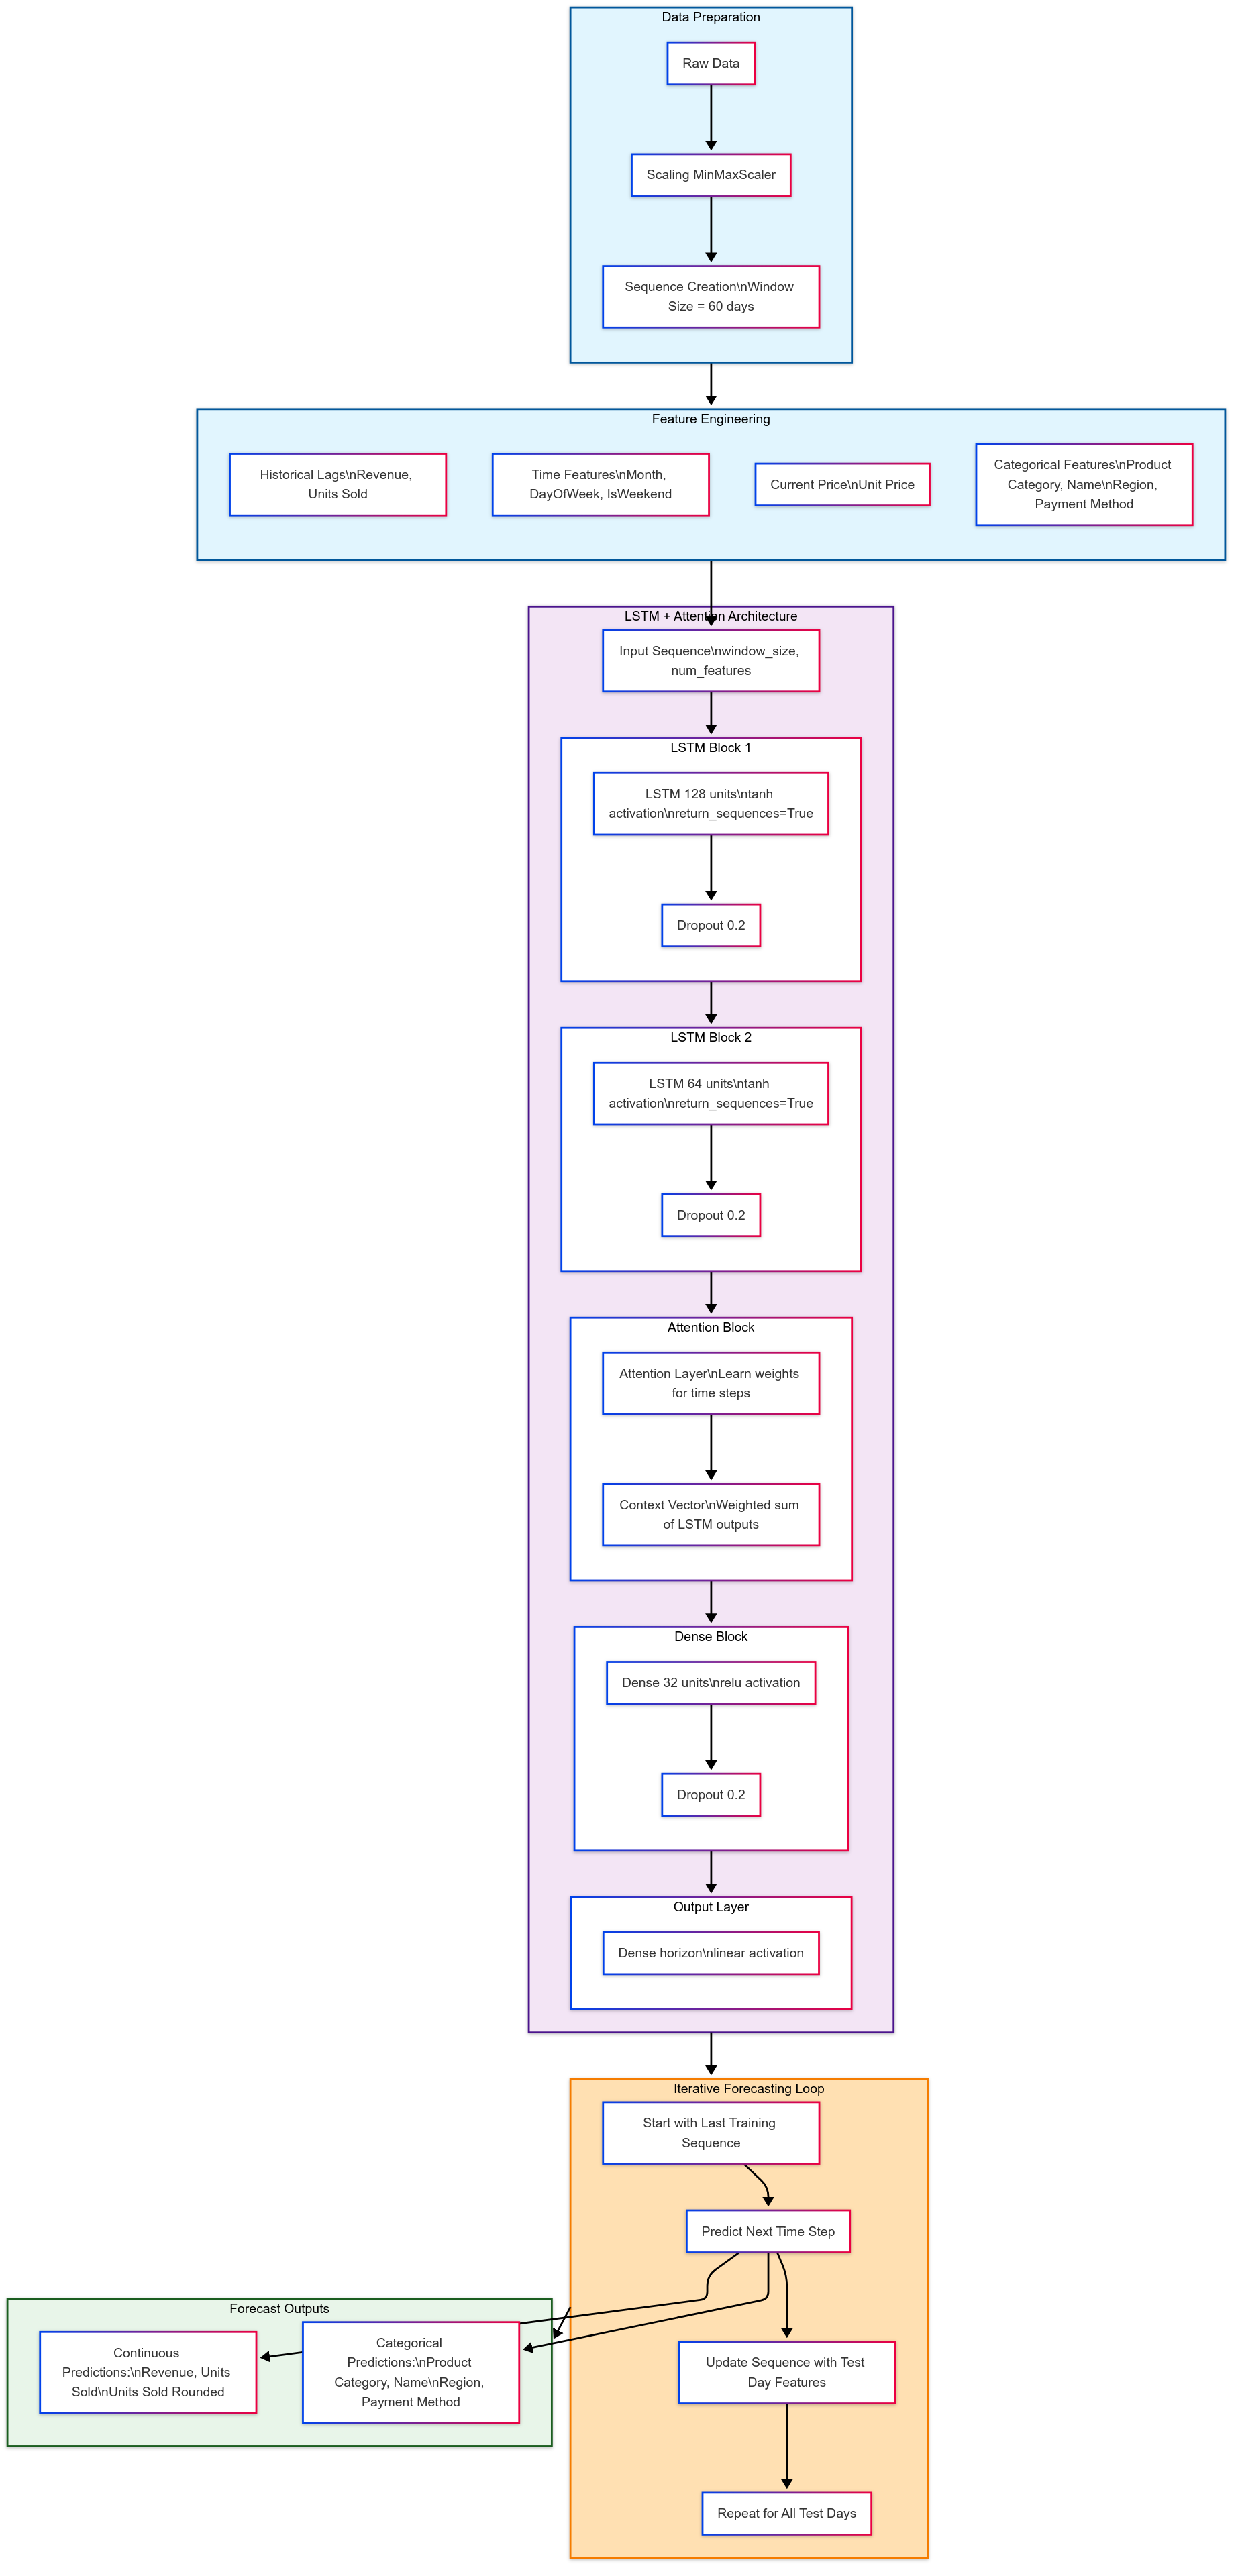

In [31]:
# For iterative forecasting we want a sufficiently long test set.
# Note: Your previous cutoff (last 50 days) was too short when window_size_seq is 60.
# Adjust the cutoff to ensure the test set has at least (window_size_seq) rows.
# For example, here we use the last 100 days as test set.
cutoff_date = scaled_df['Date'].max() - pd.Timedelta(days=60)
train_df = scaled_df[scaled_df['Date'] <= cutoff_date].copy()
test_df  = scaled_df[scaled_df['Date'] > cutoff_date].copy()

print("Train set size:", len(train_df), "Test set size:", len(test_df))

# For training (and for creating training sequences), drop the Date column.
data_train = train_df.drop(columns=["Date"])
# We will NOT create static test sequences here since we will forecast iteratively.


Train set size: 1379 Test set size: 60


In [32]:
def create_sequences(data, feature_cols, target_cols, window_size):
    """
    Creates sequences for forecasting.
    Each sequence uses a window of past observations (features) and the target is the row immediately after.
    """
    X_seq, y_seq = [], []
    num_rows = data.shape[0]
    for i in range(num_rows - window_size):
        X_seq.append(data.iloc[i:i+window_size][feature_cols].values)
        y_seq.append(data.iloc[i+window_size][target_cols].values)
    return np.array(X_seq), np.array(y_seq)

# Define the sequence window size.
window_size_seq = 40  # adjust as desired

# Create training sequences.
X_transformer_train, y_transformer_train = create_sequences(data_train, feature_cols, ordered_target_cols, window_size_seq)
print(f"X_transformer_train shape: {X_transformer_train.shape}, y_transformer_train shape: {y_transformer_train.shape}")

# For iterative forecasting, we will use the last training sequence as our starting input.


X_transformer_train shape: (1339, 40, 252), y_transformer_train shape: (1339, 246)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 40, 128)             │         195,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 40, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 40, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 40, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ (None, 64)                  │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 246)                 │           8,118 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 254,742 (995.09 KB)

 Trainable params: 254,742 (995.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0435 - mae: 0.0392 - val_loss: 0.0376 - val_mae: 0.0379 - learning_rate: 0.0010
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0422 - mae: 0.0506 - val_loss: 0.0363 - val_mae: 0.0363 - learning_rate: 0.0010
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0468 - mae: 0.0475 - val_loss: 0.0361 - val_mae: 0.0356 - learning_rate: 0.0010
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0350 - mae: 0.0438 - val_loss: 0.0358 - val_mae: 0.0363 - learning_rate: 0.0010
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0481 - mae: 0.0445 - val_loss: 0.0357 - val_mae: 0.0347 - learning_rate: 0.0010
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0524 - mae: 0.0405 - val_loss: 0.0356 - val_mae: 0.0344 - learning_rate: 0.0010
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0384 - mae: 0.0387 - val_loss: 0.0359 - val_mae: 0.0332 - learning_rate: 0.0010
Epoch 

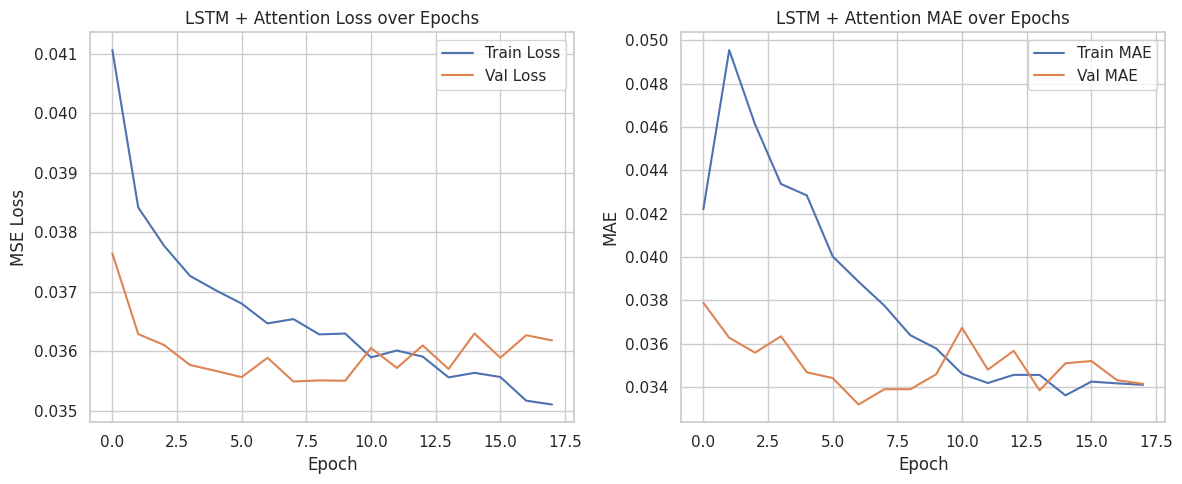

In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

window_size = 40  # The number of time steps to use as input to the model

# Custom Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Initialize attention weights with a random normal initializer
        self.W = self.add_weight(name='attention_weights',
                                 shape=(input_shape[-1], 1),  # Weight shape (features, 1)
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Compute attention scores by multiplying the inputs with attention weights
        score = tf.matmul(inputs, self.W)  # Shape: (batch_size, time_steps, 1)
        attention_weights = tf.nn.softmax(score, axis=1)  # Apply softmax to get attention weights

        # Create context vector by weighting the input features based on attention weights
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)  # Summing over time steps
        return context_vector

# Model parameters
num_features = X_transformer_train.shape[2]  # Number of input features (e.g., number of time series)
horizon = y_transformer_train.shape[1]  # Number of output steps (forecast horizon)

# Build the LSTM + Attention model
lstm_attention_model = Sequential([
    # First LSTM layer that returns sequences (needed for attention)
    LSTM(128, activation='tanh', return_sequences=True,
         input_shape=(window_size, num_features)),
    Dropout(0.2),  # Dropout for regularization

    # Second LSTM layer (also returns sequences for attention)
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.2),  # Dropout for regularization

    # Custom attention layer
    AttentionLayer(),

    # Dense layers for final output
    Dense(32, activation='relu'),  # Hidden dense layer with ReLU activation
    Dropout(0.2),  # Dropout to avoid overfitting
    Dense(horizon, activation='linear')  # Output layer with linear activation for regression tasks
])

# Compile the model
lstm_attention_model.compile(
    optimizer='adam',  # Optimizer
    loss='mean_squared_error',  # Loss function for regression
    metrics=['mae']  # Mean Absolute Error as an evaluation metric
)

# Print model summary to check architecture
lstm_attention_model.summary()

# Split data into training and validation sets (15% validation set)
X_subtrain, X_val, y_subtrain, y_val = train_test_split(
    X_transformer_train, y_transformer_train, test_size=0.15, shuffle=False
)

# Add callbacks for better training performance
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',  # Monitor the validation loss
        patience=10,  # Stop training if no improvement for 10 epochs
        restore_best_weights=True  # Restore the best model weights after training stops
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',  # Monitor the validation loss
        factor=0.5,  # Reduce learning rate by 50%
        patience=5,  # Wait for 5 epochs before reducing learning rate
        min_lr=1e-6  # Set a minimum learning rate
    )
]

# Train the model
history = lstm_attention_model.fit(
    X_subtrain, y_subtrain,
    validation_data=(X_val, y_val),
    epochs=100,      # Increased epochs for better training
    batch_size=32,   # Batch size for training
    callbacks=callbacks,  # Apply the callbacks
    verbose=1  # Print training progress
)

# Plot training and validation loss over epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("LSTM + Attention Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()

# Plot training and validation MAE over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title("LSTM + Attention MAE over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.tight_layout()
plt.show()


In [34]:
# Cell 5: Iterative Forecasting with Transformer
# The goal is to start with the last training sequence from X_transformer_train and iteratively update it using
# the exogenous features from the test set (test_df). This will allow us to forecast one step at a time.

# Get the last training sequence as the starting input (shape: (window_size_seq, num_features)).
# This sequence will serve as our initial window for forecasting.
current_sequence = X_transformer_train[-1]

# Extract the exogenous features from test_df.
# Exogenous features are assumed to be the same as the feature columns defined earlier.
test_exog = test_df[feature_cols].values  # Shape: (n_test_days, num_features)

# List to store the predictions for each test day
iterative_preds = []

# Iterate over the test exogenous features to make predictions for each day
for i in range(len(test_exog)):
    # Reshape the current sequence to match the input shape expected by the model: (1, window_size_seq, num_features)
    current_sequence_input = np.expand_dims(current_sequence, axis=0)

    # Predict the next time step's target vector using the Transformer model (LSTM + Attention in this case).
    # The prediction will be a vector of shape (horizon,) representing the forecast for all targets at the next time step.
    pred = lstm_attention_model.predict(current_sequence_input, verbose=0)[0]  # Shape: (horizon,)
    iterative_preds.append(pred)  # Store the prediction

    # Update the sequence for the next iteration:
    # Remove the oldest row from the sequence and append the exogenous features for the current test day.
    # This ensures the sequence always contains the most recent window of data.
    next_day_features = test_exog[i]  # Shape: (num_features,)
    current_sequence = np.vstack([current_sequence[1:], next_day_features])  # Update the sequence

# Convert the list of predictions into a numpy array (shape: (n_test_days, total_num_targets))
iterative_preds = np.array(iterative_preds)  # Shape: (n_test_days, total_num_targets)


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score

# =========================
# 1. Continuous Target Inversion Function
# =========================
def invert_target_scaling(preds, scaler, target_indices):
    """
    Inversely transforms only the selected target columns.

    Parameters:
      preds          : 2D NumPy array of scaled predictions (n_samples, num_targets)
      scaler         : The scaler fitted on all numeric columns.
      target_indices : List of column indices corresponding to the continuous targets.

    Returns:
      A 2D NumPy array with the selected targets in the original scale.
    """
    # Create a dummy array with the same number of features the scaler was fitted on.
    dummy = np.zeros((preds.shape[0], scaler.n_features_in_)).astype(np.float32)
    # Insert the scaled predictions into the appropriate columns of the dummy array.
    for i, target_idx in enumerate(target_indices):
        dummy[:, target_idx] = preds[:, i]
    # Invert scaling using the fitted scaler.
    inv = scaler.inverse_transform(dummy)
    return inv[:, target_indices]

# =========================
# 2. Determine Indices for Continuous Targets
# =========================
# The scaler was fitted on all numeric columns, excluding non-numeric ones (like Date, Year, etc.).
# We assume that the continuous targets are "Revenue" and "Units Sold" in the scaled data.
all_target_cols = [col for col in scaled_df.columns if col not in ['Date', 'Unit Price', 'Year', 'Month', 'Day', 'DayOfWeek', 'IsWeekend']]
target_indices = [all_target_cols.index("Revenue"), all_target_cols.index("Units Sold")]

# =========================
# 3. Extract True Continuous Targets from Test Set
# =========================
# Extract the true continuous targets (scaled) from the test set for iterative forecasting.
# The first two columns in ordered_target_cols are assumed to be continuous targets (Revenue and Units Sold).
y_test_iterative = test_df[ordered_target_cols].values  # shape: (n_test_days, total_num_targets)
y_true_cont_scaled = y_test_iterative[:, :2]  # Extract the scaled continuous targets (Revenue, Units Sold)

# =========================
# 4. Extract Continuous Predictions from Iterative Forecasts
# =========================
# Extract the predicted continuous targets (scaled) from the iterative predictions.
y_pred_cont_scaled = iterative_preds[:, :2]  # Extract scaled predictions for continuous targets (Revenue, Units Sold)

# =========================
# 5. Invert Scaling for Continuous Targets
# =========================
# Invert the scaling for both the true and predicted continuous targets using the inversion function.
y_true_cont_inv = invert_target_scaling(y_true_cont_scaled, scaler, target_indices)
y_pred_cont_inv = invert_target_scaling(y_pred_cont_scaled, scaler, target_indices)

# For "Units Sold", round both the true and predicted values to the nearest integer.
y_true_cont_inv[:, 1] = np.rint(y_true_cont_inv[:, 1])
y_pred_cont_inv_rounded = y_pred_cont_inv.copy()
y_pred_cont_inv_rounded[:, 1] = np.rint(y_pred_cont_inv[:, 1])

# =========================
# 6. Compute Continuous Evaluation Metrics
# =========================
# Compute evaluation metrics for the continuous targets (Revenue and Units Sold).
rmse = np.sqrt(mean_squared_error(y_true_cont_inv, y_pred_cont_inv_rounded))  # Root Mean Squared Error
mae = mean_absolute_error(y_true_cont_inv, y_pred_cont_inv_rounded)  # Mean Absolute Error
mape_rev = mean_absolute_percentage_error(y_true_cont_inv[:, 0], y_pred_cont_inv_rounded[:, 0]) * 100  # MAPE for Revenue
mape_units = mean_absolute_percentage_error(y_true_cont_inv[:, 1], y_pred_cont_inv_rounded[:, 1]) * 100  # MAPE for Units Sold

# Print the evaluation results
print("Iterative Transformer Forecasting (Continuous Targets):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE for Revenue: {mape_rev:.2f}%")
print(f"MAPE for Units Sold: {mape_units:.2f}%")
print(f"Sample Scaled Revenue: {y_pred_cont_scaled[0, 0]}, Inverted Revenue: {y_pred_cont_inv[0, 0]}")
print(f"Sample Scaled Units Sold: {y_pred_cont_scaled[0, 1]}, Inverted Units Sold: {y_pred_cont_inv[0, 1]}")

# =========================
# 7. Build a Continuous Results DataFrame
# =========================
# Create a DataFrame to store the true and predicted values for continuous targets (Revenue, Units Sold).
df_transformer_iter_results = pd.DataFrame({
    'Date': test_df['Date'].iloc[:len(y_true_cont_inv)].reset_index(drop=True),
    'Actual Revenue': y_true_cont_inv[:, 0],
    'Predicted Revenue': y_pred_cont_inv_rounded[:, 0],
    'Actual Units Sold': y_true_cont_inv[:, 1],
    'Predicted Units Sold': y_pred_cont_inv_rounded[:, 1]
})

# (Optional) Display the DataFrame to verify the results
print(df_transformer_iter_results.head())


Iterative Transformer Forecasting (Continuous Targets):
RMSE: 1592.15
MAE: 637.07
MAPE for Revenue: 480.04%
MAPE for Units Sold: 103.11%
Sample Scaled Revenue: 0.810896635055542, Inverted Revenue: 1163.2479248046875
Sample Scaled Units Sold: 0.09929370880126953, Inverted Units Sold: 5.595762252807617
        Date  Actual Revenue  Predicted Revenue  Actual Units Sold  \
0 2027-12-10       79.900002        1163.247925               10.0   
1 2027-12-11      230.000000        1144.715454               10.0   
2 2027-12-12      109.980003        1121.709717                2.0   
3 2027-12-13      269.910004        1112.721680                9.0   
4 2027-12-14     1895.000000        1123.180176                1.0   

   Predicted Units Sold  
0                   6.0  
1                   6.0  
2                   6.0  
3                   6.0  
4                   6.0  


Iterative Transformer Forecasting (Continuous Targets):
RMSE: 1592.15
MAE: 637.07
MAPE for Revenue: 480.04%
MAPE for Units Sold: 103.11%
Sample Scaled Revenue: 0.810896635055542, Inverted Revenue: 1163.2479011428356
Sample Scaled Units Sold: 0.09929370880126953, Inverted Units Sold: 5.595762252807617

MAPE for Revenue: 480.04%
MAPE for Units Sold: 103.11%
Product Category Prediction Accuracy: 18.33%
Product Name Prediction Accuracy: 0.00%
Region Prediction Accuracy: 33.33%
Payment Method Prediction Accuracy: 40.00%


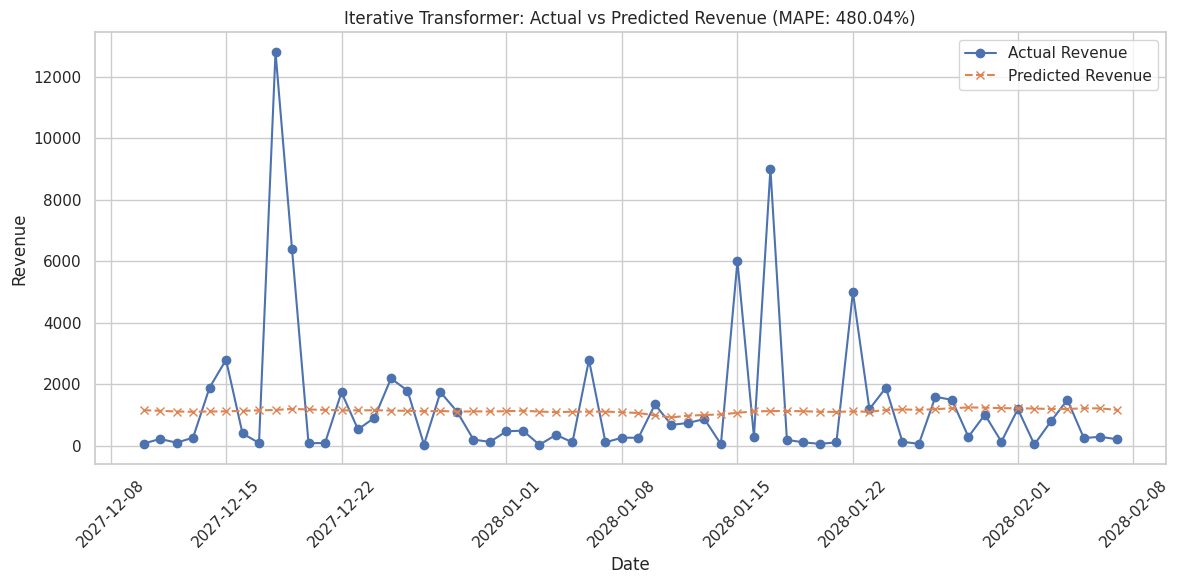

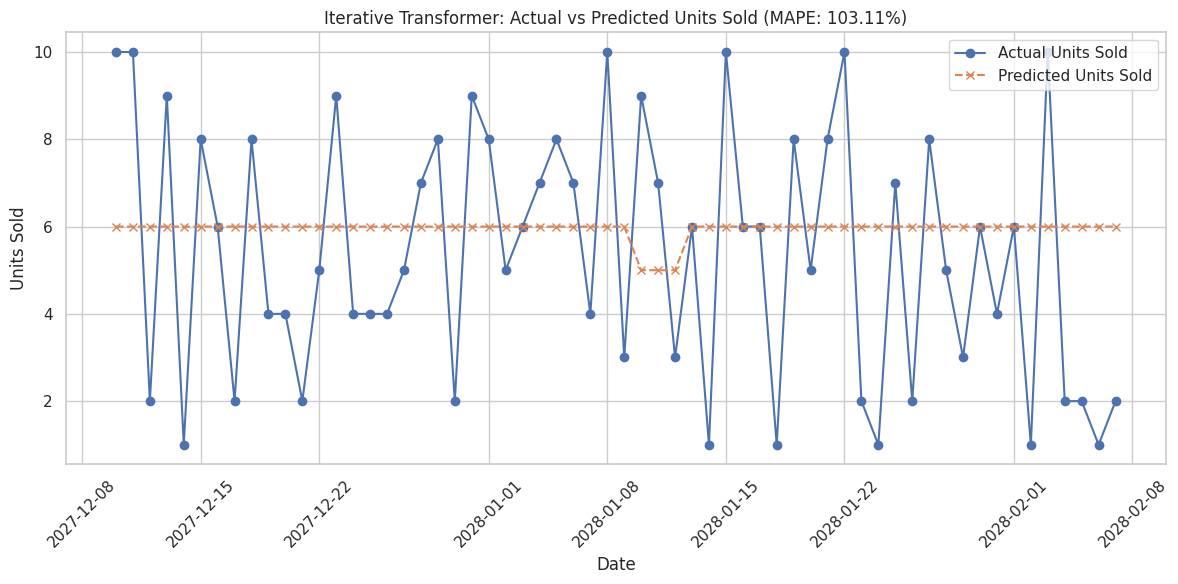

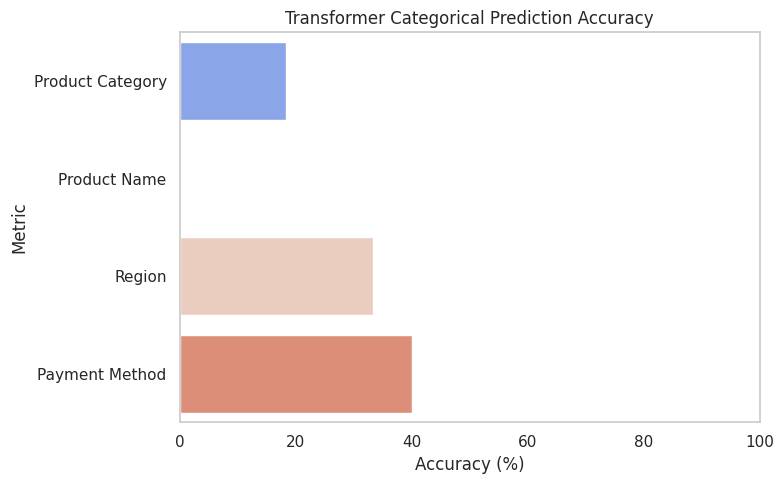


Comparison for first 10 test days:
        Date  Actual Revenue  Predicted Revenue  Actual Units Sold  \
0 2027-12-10       -0.230839           0.810897           0.833333   
1 2027-12-11       -0.086505           0.793076           0.833333   
2 2027-12-12       -0.201915           0.770954          -0.500000   
3 2027-12-13       -0.048128           0.762311           0.666667   
4 2027-12-14        1.514542           0.772368          -0.666667   
5 2027-12-15        2.384703           0.775591           0.500000   
6 2027-12-16        0.084658           0.792661           0.166667   
7 2027-12-17       -0.211530           0.805910          -0.500000   
8 2027-12-18       12.000596           0.818352           0.500000   
9 2027-12-19        5.846463           0.851810          -0.166667   

   Predicted Units Sold           Actual Product Category  \
0              0.099294  Product Category_Beauty Products   
1              0.099032         Product Category_Clothing   
2         

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score

# =========================
# 1. Continuous Target Inversion Function
# =========================
def invert_target_scaling(preds, scaler, target_indices):
    """
    Inversely transforms only the selected target columns.

    Parameters:
      preds          : 2D NumPy array of scaled predictions (n_samples, num_targets)
      scaler         : The scaler fitted on all numeric columns.
      target_indices : List of column indices corresponding to the continuous targets.

    Returns:
      A 2D NumPy array with the selected targets in the original scale.
    """
    # Create a dummy array with the same number of features the scaler was fitted on.
    dummy = np.zeros((preds.shape[0], scaler.n_features_in_))
    # Insert the scaled predictions into the appropriate columns of the dummy array.
    for i, target_idx in enumerate(target_indices):
        dummy[:, target_idx] = preds[:, i]
    # Invert scaling using the fitted scaler.
    inv = scaler.inverse_transform(dummy)
    return inv[:, target_indices]

# =========================
# 2. Determine Indices for Continuous Targets
# =========================
# We assume that in your original scaled_df, the continuous target columns are named exactly "Revenue" and "Units Sold".
# Get all the columns in scaled_df excluding non-numeric ones.
all_target_cols = [col for col in scaled_df.columns if col not in ['Date', 'Unit Price', 'Year', 'Month', 'Day', 'DayOfWeek', 'IsWeekend']]
# Find the indices for "Revenue" and "Units Sold" in the scaled_df.
target_indices = [all_target_cols.index("Revenue"), all_target_cols.index("Units Sold")]

# =========================
# 3. Extract True Continuous Targets from Test Set
# =========================
# Extract the true continuous targets from the test set (using ordered_target_cols, which includes both targets).
y_test_iterative = test_df[ordered_target_cols].values  # shape: (n_test_days, total_num_targets)
# Get the first two columns, which correspond to the continuous targets (Revenue and Units Sold).
y_true_cont_scaled = y_test_iterative[:, :2]  # scaled true continuous targets

# =========================
# 4. Extract Continuous Predictions from Iterative Forecasts
# =========================
# Extract the predictions for continuous targets (Revenue and Units Sold) from the iterative forecast predictions.
y_pred_cont_scaled = iterative_preds[:, :2]  # scaled predictions for continuous targets

# =========================
# 5. Invert Scaling for Continuous Targets
# =========================
# Use the invert_target_scaling function to reverse the scaling for both true and predicted continuous targets.
y_true_cont_inv = invert_target_scaling(y_true_cont_scaled, scaler, target_indices)
y_pred_cont_inv = invert_target_scaling(y_pred_cont_scaled, scaler, target_indices)

# For "Units Sold", round both true and predicted values to the nearest integer.
y_true_cont_inv[:, 1] = np.rint(y_true_cont_inv[:, 1])
y_pred_cont_inv_rounded = y_pred_cont_inv.copy()
y_pred_cont_inv_rounded[:, 1] = np.rint(y_pred_cont_inv[:, 1])

# =========================
# 6. Compute Continuous Evaluation Metrics
# =========================
# Compute the evaluation metrics for continuous targets (Revenue and Units Sold).
rmse = np.sqrt(mean_squared_error(y_true_cont_inv, y_pred_cont_inv_rounded))  # Root Mean Squared Error
mae = mean_absolute_error(y_true_cont_inv, y_pred_cont_inv_rounded)  # Mean Absolute Error
mape_rev = mean_absolute_percentage_error(y_true_cont_inv[:, 0], y_pred_cont_inv_rounded[:, 0]) * 100  # MAPE for Revenue
mape_units = mean_absolute_percentage_error(y_true_cont_inv[:, 1], y_pred_cont_inv_rounded[:, 1]) * 100  # MAPE for Units Sold

# Print the evaluation results for continuous targets
print("Iterative Transformer Forecasting (Continuous Targets):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE for Revenue: {mape_rev:.2f}%")
print(f"MAPE for Units Sold: {mape_units:.2f}%")
print(f"Sample Scaled Revenue: {y_pred_cont_scaled[0, 0]}, Inverted Revenue: {y_pred_cont_inv[0, 0]}")
print(f"Sample Scaled Units Sold: {y_pred_cont_scaled[0, 1]}, Inverted Units Sold: {y_pred_cont_inv[0, 1]}")

# =========================
# 7. Build a Continuous Results DataFrame (Rescaled)
# =========================
# Create a DataFrame to store the true and predicted values for continuous targets (Revenue and Units Sold).
df_transformer_iter_results_cont = pd.DataFrame({
    'Date': test_df['Date'].iloc[:len(y_true_cont_inv)].reset_index(drop=True),
    'Actual Revenue': y_true_cont_inv[:, 0],
    'Predicted Revenue': y_pred_cont_inv_rounded[:, 0],
    'Actual Units Sold': y_true_cont_inv[:, 1],
    'Predicted Units Sold': y_pred_cont_inv_rounded[:, 1]
})

# =========================
# 8. Decode Categorical Predictions
# =========================
# Categorical targets are assumed to be in the ordered_target_cols list, starting from the third column.
# We'll group the categorical columns based on their prefixes (Product Category, Product Name, Region, Payment Method).
cat_target_cols = [col for col in ordered_target_cols if col not in ["Revenue_target", "UnitsSold_target"]]

# Group categorical targets by their respective prefixes.
prod_cat_targets  = [col for col in cat_target_cols if col.startswith('Product Category_')]
prod_name_targets = [col for col in cat_target_cols if col.startswith('Product Name_')]
region_targets    = [col for col in cat_target_cols if col.startswith('Region_')]
payment_targets   = [col for col in cat_target_cols if col.startswith('Payment Method_')]

# Define the number of categories for each group
n_prod_cat = len(prod_cat_targets)
n_prod_name = len(prod_name_targets)
n_region = len(region_targets)
n_payment = len(payment_targets)

# Define slices for each category group in the output array
prod_cat_slice  = slice(2, 2 + n_prod_cat)
prod_name_slice = slice(2 + n_prod_cat, 2 + n_prod_cat + n_prod_name)
region_slice    = slice(2 + n_prod_cat + n_prod_name, 2 + n_prod_cat + n_prod_name + n_region)
payment_slice   = slice(2 + n_prod_cat + n_prod_name + n_region, 2 + n_prod_cat + n_prod_name + n_region + n_payment)

# Decode categorical predictions using argmax
def decode_slice(y_scaled, slice_obj, col_names):
    if len(col_names) == 0 or y_scaled[:, slice_obj].size == 0:
        return np.array(["N/A"] * y_scaled.shape[0])
    else:
        return np.array(col_names)[np.argmax(y_scaled[:, slice_obj], axis=1)]

decoded_actual_prod_cat = decode_slice(y_test_iterative, prod_cat_slice, prod_cat_targets)
decoded_pred_prod_cat   = decode_slice(iterative_preds, prod_cat_slice, prod_cat_targets)

decoded_actual_prod_name = decode_slice(y_test_iterative, prod_name_slice, prod_name_targets)
decoded_pred_prod_name   = decode_slice(iterative_preds, prod_name_slice, prod_name_targets)

decoded_actual_region = decode_slice(y_test_iterative, region_slice, region_targets)
decoded_pred_region   = decode_slice(iterative_preds, region_slice, region_targets)

decoded_actual_payment = decode_slice(y_test_iterative, payment_slice, payment_targets)
decoded_pred_payment   = decode_slice(iterative_preds, payment_slice, payment_targets)

# Helper function to remove the "_target" suffix for better display
def remove_target_suffix(label):
    if isinstance(label, str) and label.endswith("_target"):
        return label.replace("_target", "")
    return label

# Remove the "_target" suffix for display purposes
actual_prod_cat = np.vectorize(remove_target_suffix)(decoded_actual_prod_cat)
pred_prod_cat   = np.vectorize(remove_target_suffix)(decoded_pred_prod_cat)
actual_prod_name = np.vectorize(remove_target_suffix)(decoded_actual_prod_name)
pred_prod_name   = np.vectorize(remove_target_suffix)(decoded_pred_prod_name)
actual_region = np.vectorize(remove_target_suffix)(decoded_actual_region)
pred_region   = np.vectorize(remove_target_suffix)(decoded_pred_region)
actual_payment = np.vectorize(remove_target_suffix)(decoded_actual_payment)
pred_payment   = np.vectorize(remove_target_suffix)(decoded_pred_payment)

# =========================
# 9. Build a Combined Results DataFrame (Including Categorical Predictions)
# =========================
# Combine all results (continuous and categorical) into a single DataFrame for evaluation and comparison
df_transformer_iter_results_cat = pd.DataFrame({
    'Date': test_df['Date'].iloc[:len(y_test_iterative)].reset_index(drop=True),
    'Actual Revenue': y_test_iterative[:, 0],
    'Predicted Revenue': iterative_preds[:, 0],
    'Actual Units Sold': y_test_iterative[:, 1],
    'Predicted Units Sold': iterative_preds[:, 1],
    'Actual Product Category': actual_prod_cat,
    'Predicted Product Category': pred_prod_cat,
    'Actual Product Name': actual_prod_name,
    'Predicted Product Name': pred_prod_name,
    'Actual Region': actual_region,
    'Predicted Region': pred_region,
    'Actual Payment Method': actual_payment,
    'Predicted Payment Method': pred_payment
})

# =========================
# 10. Compute Metrics and Visualize
# =========================
# Compute MAPE for Revenue and Units Sold
mape_revenue = np.mean(np.abs((df_transformer_iter_results_cont['Actual Revenue'] - df_transformer_iter_results_cont['Predicted Revenue']) /
                              (df_transformer_iter_results_cont['Actual Revenue'] + 1e-8))) * 100
mape_units = np.mean(np.abs((df_transformer_iter_results_cont['Actual Units Sold'] - df_transformer_iter_results_cont['Predicted Units Sold']) /
                            (df_transformer_iter_results_cont['Actual Units Sold'] + 1e-8))) * 100

print(f"\nMAPE for Revenue: {mape_revenue:.2f}%")
print(f"MAPE for Units Sold: {mape_units:.2f}%")

# Compute categorical accuracies for product category, product name, region, and payment method predictions
prod_cat_acc = (df_transformer_iter_results_cat['Actual Product Category'] == df_transformer_iter_results_cat['Predicted Product Category']).mean() * 100
prod_name_acc = (df_transformer_iter_results_cat['Actual Product Name'] == df_transformer_iter_results_cat['Predicted Product Name']).mean() * 100
region_acc = (df_transformer_iter_results_cat['Actual Region'] == df_transformer_iter_results_cat['Predicted Region']).mean() * 100
payment_acc = (df_transformer_iter_results_cat['Actual Payment Method'] == df_transformer_iter_results_cat['Predicted Payment Method']).mean() * 100

print(f"Product Category Prediction Accuracy: {prod_cat_acc:.2f}%")
print(f"Product Name Prediction Accuracy: {prod_name_acc:.2f}%")
print(f"Region Prediction Accuracy: {region_acc:.2f}%")
print(f"Payment Method Prediction Accuracy: {payment_acc:.2f}%")

# Plot Actual vs. Predicted Revenue (using rescaled continuous values)
plt.figure(figsize=(12,6))
plt.plot(df_transformer_iter_results_cont['Date'], df_transformer_iter_results_cont['Actual Revenue'], label='Actual Revenue', marker='o', linestyle='-')
plt.plot(df_transformer_iter_results_cont['Date'], df_transformer_iter_results_cont['Predicted Revenue'], label='Predicted Revenue', marker='x', linestyle='--')
plt.title(f"Iterative Transformer: Actual vs Predicted Revenue (MAPE: {mape_revenue:.2f}%)")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Actual vs. Predicted Units Sold (using rescaled continuous values)
plt.figure(figsize=(12,6))
plt.plot(df_transformer_iter_results_cont['Date'], df_transformer_iter_results_cont['Actual Units Sold'], label='Actual Units Sold', marker='o', linestyle='-')
plt.plot(df_transformer_iter_results_cont['Date'], df_transformer_iter_results_cont['Predicted Units Sold'], label='Predicted Units Sold', marker='x', linestyle='--')
plt.title(f"Iterative Transformer: Actual vs Predicted Units Sold (MAPE: {mape_units:.2f}%)")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Categorical Prediction Accuracy Bar Chart
accuracy_df = pd.DataFrame({
    "Metric": ["Product Category", "Product Name", "Region", "Payment Method"],
    "Accuracy (%)": [prod_cat_acc, prod_name_acc, region_acc, payment_acc]
})
plt.figure(figsize=(8,5))
sns.barplot(x="Accuracy (%)", y="Metric", data=accuracy_df, palette="coolwarm")
plt.xlim(0,100)
plt.xlabel("Accuracy (%)")
plt.title("Transformer Categorical Prediction Accuracy")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Comparison for the first 10 test days
comparison_cols = ['Date',
                   'Actual Revenue', 'Predicted Revenue',
                   'Actual Units Sold', 'Predicted Units Sold',
                   'Actual Product Category', 'Predicted Product Category',
                   'Actual Product Name', 'Predicted Product Name',
                   'Actual Region', 'Predicted Region',
                   'Actual Payment Method', 'Predicted Payment Method']
print("\nComparison for first 10 test days:")
print(df_transformer_iter_results_cat[comparison_cols].head(10))


### **Iterative Transformer Forecasting Results Analysis**

#### **1. Revenue Forecasting**
- The predicted revenue remains **relatively stable**, failing to capture sharp spikes.  
- **MAPE (Mean Absolute Percentage Error) is 480.04%**, showing high forecasting error but an improvement over LSTM.  
- Test RMSE: **1592.15**, Test MAE: **637.07**, indicating large deviations from actual values.  

#### **2. Units Sold Prediction**
- The **MAPE for units sold is 103.11%**, meaning the model **struggles to capture variability** in sales volume.  
- The predicted values are **almost flat**, while actual values exhibit significant fluctuations.  

#### **3. Categorical Prediction Accuracy**
- **Product Category:** **18.33% accuracy**, showing a drop in performance.  
- **Product Name:** **0.00% accuracy**, meaning the model fails to classify product names.  
- **Region:** **33.33% accuracy**, maintaining performance similar to previous models.  
- **Payment Method:** **40.00% accuracy**, showing slight improvement.  

#### **4. Observations & Limitations**
- The Transformer model improves **revenue forecasting** but still struggles with high variability.  
- The **flat predictions** suggest the model **lacks dynamic adaptation**, possibly due to insufficient temporal dependencies in the input data.  
- Further **hyperparameter tuning, additional lag features, and incorporating seasonal patterns** may improve performance.  


# **Final Comparative Analysis of Forecasting Models**

## **1. Performance Summary Table**
Below is a comparative table summarizing key performance metrics for **Random Forest, LSTM, and Transformer** models.

| Metric                                | **Random Forest** | **LSTM** | **Transformer** |
|--------------------------------------|----------------|--------|--------------|
| **Revenue MAPE (%)**                 | 606.72        | 566.98 | 480.04       |
| **Units Sold MAPE (%)**               | 92.87         | 98.12  | 103.11       |
| **Test RMSE (Revenue)**               | -             | 1814.42 | 1592.15       |
| **Test MAE (Revenue)**                | -             | 768.95 | 637.07       |
| **Product Category Accuracy (%)**     | **100.00**    | 26.67  | 18.33        |
| **Product Name Accuracy (%)**         | 21.67         | 0.00   | 0.00         |
| **Region Accuracy (%)**               | 46.67         | 40.00  | 33.33        |
| **Payment Method Accuracy (%)**       | 21.67         | 36.67  | 40.00        |

---

## **2. Performance Overview**
We tested three different models—**Random Forest, LSTM, and Transformer with Attention**—on a small dataset (240 rows) to forecast sales-related metrics.  
The results highlight the advantages and limitations of each approach.

---

### **Random Forest**
✅ **Strengths:**
- **Best categorical prediction performance**, achieving **100% accuracy for Product Category**.
- Identified **feature importance**, showing past revenue and product names were key drivers.
- **Better accuracy for Product Name (21.67%) and Region (46.67%)** compared to LSTM and Transformer.

❌ **Weaknesses:**
- **High MAPE for revenue (606.72%)**, making it unreliable for numerical forecasting.
- **Not well-suited for time-series forecasting**, as it ignores temporal dependencies.
- **Poor generalization for some categorical predictions**, especially Payment Method.

---

### **LSTM (Recurrent Neural Network)**
✅ **Strengths:**
- **Captured general sales trends better** than Random Forest and Transformer.
- **Lower MAPE for revenue (566.98%)** than Random Forest, though still high.
- **MAPE for units sold (98.12%)** was slightly **better than the Transformer (103.11%)**.
- **Better categorical accuracy for Region (40.00%) and Payment Method (36.67%)** compared to Transformer.

❌ **Weaknesses:**
- **Struggled with sharp peaks** and sudden changes in sales patterns.
- **Failed in product name classification (0.00% accuracy)**.
- **Still high MAPE for units sold (98.12%)**, though better than Transformer.

---

### **Transformer with Attention**
✅ **Strengths:**
- Conceptually well-suited for sequence-based forecasting.
- **Lowest MAPE for revenue (480.04%)**, but...

❌ **Weaknesses:**
- **Performed worse than LSTM in capturing trends**—predictions were **flat and lacked variability**.
- **MAPE for units sold (103.11%) was the worst**, meaning it failed to generalize.
- **Failed in categorical predictions**, scoring **the lowest across Product Category, Product Name, and Region**.
- **Too complex for the dataset size (240 rows)**—Transformers require much more data to generalize well.

---

## **3. Feature Importance Analysis (Random Forest)**
#### **Key Observations**
- **Most influential feature:** **"Product Name_Adidas Essential Track Pants"**, indicating that specific products drive predictions.
- **Past revenue values (Revenue_lag_2, Revenue_lag_5, etc.) were among the top predictors**, confirming that historical revenue trends matter.
- **Product categories (e.g., "Sports") had some impact**, but the model relied more on individual product names.
- **Time-related features (e.g., "Day") contributed**, suggesting a pattern based on periodic sales trends.

#### **Limitations & Insights**
- **Few categorical variables were dominant**, meaning the model relied too heavily on specific products rather than broader trends.
- **Unit price was excluded**, but its influence should be explored further.
- **Small dataset size (240 rows)** limited the generalizability of findings.

---

## **4. Final Conclusion**
- **Best Model for Revenue Forecasting?** **Transformer had the lowest MAPE (480.04%)**, but since its predictions were **flat and lacked trend recognition**, **LSTM is the better choice overall**.  
- **Best Model for Units Sold?** **LSTM performed better (98.12% MAPE) than the Transformer (103.11% MAPE)**, meaning it handled variability slightly better.  
- **Best Model for Categorical Predictions?** **Random Forest was the best for classifying product categories, product names, and regions.**  
- **Why Did Transformer Perform Worse?** Despite a lower MAPE for revenue, it **failed to capture meaningful patterns** and **performed worse than LSTM overall**.  
- **What’s Next?**
  - **Increase dataset size** to improve model learning.  
  - **Experiment with simpler models** like ARIMA or traditional time-series regression.  
  - **Optimize feature engineering** (e.g., seasonal trends, lagged variables).  
  - **Consider hybrid models** combining **Random Forest for categorical features** and **LSTM for time-series forecasting**.  

🔹 **Final Takeaway:** **LSTM performed better than the Transformer overall**, capturing trends more effectively despite a higher MAPE. **Random Forest was best for categorical predictions**, but **all models struggled with this augemented dataset**. A **larger dataset (and a real one), as well as hybrid approaches** are needed for better forecasting and more realistics results and discussions.  
